<a href="https://colab.research.google.com/github/YANG-SOBER/EECS-498-598-Deep-Learning-for-Computer-Vision/blob/main/Asgn-5/single_stage_detector_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EECS 498-007/598-005 Assignment 5-1: Single-Stage Object Detector - YOLO

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Guidong YANG, 1155170424

# Single-Stage Object Detector
In this exercise you will implement a **single-stage** object detector, based on YOLO ([v1](https://arxiv.org/pdf/1506.02640.pdf) and [v2](https://arxiv.org/pdf/1612.08242.pdf)) and use it to train a model that can detect objects on novel images. We will also evaluate the detection accuracy using the classic metric mean Average Precision ([mAP](https://github.com/Cartucho/mAP)). In Part II of A5, you will implement a **two-stage** object detector, based on [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf). The main difference between the two is that single-stage detectors perform region proposal and classification simultaneously while two-stage detectors have them decoupled. 

Tasks:

1. Implement a **single-stage** object detector, based on YOLO;
2. Evaluate the **detection accuracy** using the classic **mean Average Precision (mAP)**;

# Getting Started

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as previous assignments. 

You'll need to **rerun this setup code each time you start the notebook**.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['single_stage_detector_yolo.ipynb', 'two_stage_detector_faster_rcnn.ipynb', 'eecs598', 'single_stage_detector.py', 'two_stage_detector.py', 'a5_helper.py']
```

In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A5 folder, then '2020FA/A5'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'A5'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['two_stage_detector_faster_rcnn.ipynb', 'single_stage_detector_yolo.ipynb', 'two_stage_detector.py', 'eecs598', '__pycache__', 'VOCtrainval_06-Nov-2007.tar', 'VOCdevkit', 'extracted.txt', 'a5_helper.py', 'single_stage_detector.py']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from single_stage_detector.py!
Hello from a5_helper.py!
```

as well as the last edit time for the file `single_stage_detector.py`.

In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from single_stage_detector import hello_single_stage_detector
hello_single_stage_detector()

from a5_helper import hello_helper
hello_helper()

single_stage_detector_path = os.path.join(GOOGLE_DRIVE_PATH, 'single_stage_detector.py')
single_stage_detector_edit_time = time.ctime(os.path.getmtime(single_stage_detector_path))
print('single_stage_detector.py last edited on %s' % single_stage_detector_edit_time)

Hello from single_stage_detector.py!
Hello from a5_helper.py!
single_stage_detector.py last edited on Mon Sep 12 09:27:27 2022


Load several useful packages that are used in this notebook:

In [5]:
import eecs598
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision # torchvision.transforms  torchvision.models  torchvision.datasets
import statistics # This module provides functions for calculating mathematical statistics of numerical data
import random # This module implements pseudo-random number generators for various distributions
import time
import math # This module provides access to mathematical functions defined by the C standard (do not support complex number) e.g. math.ceil() math.floor() math.pi
import numpy as np
import cv2
import copy # This module provides generic shallow and deep copy operations
import shutil # This module provides files which support ** file copying and removal ** e.g. shutil.move(src, dest)
import os
import json # JavaScript Object Notation: a lightweight data interchange format

import matplotlib.pyplot as plt
# a magic function that shows the graph and record it in the notebook
%matplotlib inline

from eecs598 import reset_seed, Solver
from eecs598.grad import rel_error

from a5_helper import *

# for plotting
# matplotlib runtime configuration parameters
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['font.size'] = 16
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for mAP evaluation
!rm -rf mAP # recursively force delete the given directory (also non-empty directories)
!git clone https://github.com/Cartucho/mAP.git
!rm -rf mAP/input/*

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 33.33 MiB/s, done.
Resolving deltas: 100% (321/321), done.


We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [6]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


## Load PASCAL VOC 2007 data
During the majority of our homework assignments so far, we have used the CIFAR-10 dataset for image classification tasks.

We will need to use a new dataset for object detection. In order to train and evaluate object detection models, we need a dataset where each image is annotated with a ***set*** of ***bounding boxes***, where ***each box*** gives the ***category label*** and ***spatial extent*** of some *object* in the image.

We will use the [PASCAL VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/) dataset, which provides annotations of this form. PASCAL VOC ran a series of yearly computer vision competitions from 2005 to 2012, predating the ImageNet challenge which we have discussed in class.

The data from the 2007 challenge used to be ***one of the most popular*** datasets for *evaluating object detection*. It is much smaller than more recent object detection datasets such as [COCO](http://cocodataset.org/#home), and thus easier to manage in an homework assignment.

The function `get_pascal_voc2007_data` in `a5_helper.py` will 

1. Download the PASCAL VOC 2007 dataset
2. Return it as a PyTorch Dataset object. 

Run the following cell to download the training and validation sets for the PASCAL VOC 2007 dataset.

The [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) objects returned from the above function returns annotations for each image as a nested set of dictionary objects.

In [7]:
def get_pascal_voc2007_data(image_root, split='train'):

  check_file = os.path.join(image_root, 'extracted.txt')
  download = not os.path.exists(check_file)
  dataset = torchvision.datasets.VOCDetection(image_root, year="2007", image_set=split,
                                              download=download)

  open(check_file, 'a').close()
  return dataset

In [8]:
# uncomment below to use the mirror link if the original link is broken and move it to GOOGLE_DRIVE_PATH
# !wget https://web.eecs.umich.edu/~justincj/data/VOCtrainval_06-Nov-2007.tar
# shutil.move('VOCtrainval_06-Nov-2007.tar', os.path.join(GOOGLE_DRIVE_PATH, 'VOCtrainval_06-Nov-2007.tar'))  
train_dataset = get_pascal_voc2007_data(GOOGLE_DRIVE_PATH, 'train')
val_dataset = get_pascal_voc2007_data(GOOGLE_DRIVE_PATH, 'val')

# an example on the raw annotation
print(json.dumps(train_dataset[1][1]['annotation'], indent=2)) # Serialize obj to a JSON formatted str using the conversion table.

{
  "folder": "VOC2007",
  "filename": "000017.jpg",
  "source": {
    "database": "The VOC2007 Database",
    "annotation": "PASCAL VOC2007",
    "image": "flickr",
    "flickrid": "228217974"
  },
  "owner": {
    "flickrid": "genewolf",
    "name": "whiskey kitten"
  },
  "size": {
    "width": "480",
    "height": "364",
    "depth": "3"
  },
  "segmented": "0",
  "object": [
    {
      "name": "person",
      "pose": "Left",
      "truncated": "0",
      "difficult": "0",
      "bndbox": {
        "xmin": "185",
        "ymin": "62",
        "xmax": "279",
        "ymax": "199"
      }
    },
    {
      "name": "horse",
      "pose": "Left",
      "truncated": "0",
      "difficult": "0",
      "bndbox": {
        "xmin": "90",
        "ymin": "78",
        "xmax": "403",
        "ymax": "336"
      }
    }
  ]
}


In [9]:
type(train_dataset)

torchvision.datasets.voc.VOCDetection

In [10]:
type(json.dumps(train_dataset[1][1]['annotation'], indent=2))

str

In [11]:
train_dataset[1]

(<PIL.Image.Image image mode=RGB size=480x364 at 0x7F76394A6390>,
 {'annotation': {'folder': 'VOC2007',
   'filename': '000017.jpg',
   'source': {'database': 'The VOC2007 Database',
    'annotation': 'PASCAL VOC2007',
    'image': 'flickr',
    'flickrid': '228217974'},
   'owner': {'flickrid': 'genewolf', 'name': 'whiskey kitten'},
   'size': {'width': '480', 'height': '364', 'depth': '3'},
   'segmented': '0',
   'object': [{'name': 'person',
     'pose': 'Left',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '185', 'ymin': '62', 'xmax': '279', 'ymax': '199'}},
    {'name': 'horse',
     'pose': 'Left',
     'truncated': '0',
     'difficult': '0',
     'bndbox': {'xmin': '90', 'ymin': '78', 'xmax': '403', 'ymax': '336'}}]}})

In order to use these annotations to train our model, we need to ***convert this nested dictionary data structure into a set of PyTorch tensors***.

We also need to ***preprocess the image***, ***converting it to a PyTorch tensor*** and ***resizing*** it to 224x224. ***Real object detection*** systems typically work with ***much higher-resolution images***, but we will use a low resolution for computational efficiency in this assignment.

We also want to train our models using minibatches of data, so we need to ***group the annotations from several images into minibatches***.

We perform both of these functions by using a customized PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) object, which we have written for you. Those functions are all available in `a5_helper.py`. 

Training with the entire PASCAL VOC will be too computationally expensive for this homework assignment, so we can **subsample the dataset** by wrapping each `Dataset` object in a [`Subset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset) object:

In [12]:
# mean=[0.485, 0.456, 0.406]
# std=[0.229, 0.224, 0.225]

def pascal_voc2007_loader(dataset, batch_size=10, num_workers=0):
  """
  DataLoader performs - tasks (in our case):
    - Resize the input PIL image;
    - Convert the PIL image to PyTorch tensor;
    - Normalize per color channel;
    - Group the annotations from several images into minibatches.
  """

  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           shuffle=False, num_workers=num_workers, 
                                           pin_memory=True,
                                           collate_fn=voc_collate_fn)
  
  return dataloader

def voc_collate_fn(batch_lst, reshape_size=224):
  """
  collate_fn:
    - Merges a list of samples to form a minibatch of tensors;
    - Used when using batched loading from a map-style dataset.
  
  Input:
    - batch_lst: length B
        - batch_lst[i] is a tuple: (PIL Image, annotation dict)
    - reshape_size: scalar
  """
  # Define preprocess operations
  preprocess = torchvision.transforms.Compose([
                                torchvision.transforms.Resize((reshape_size, reshape_size)),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225],)])
  
  # Initialization
  batch_size = len(batch_lst) # B

  img_batch = torch.zeros(size=(batch_size, 3, reshape_size, reshape_size), dtype=torch.float32) # (B, 3, 224, 224)

  # maximum number of bounding boxes appeared in a single image within the batch
  max_num_bbox = max(len(batch_lst[i][1]['annotation']['object']) for i in range(batch_size))
  box_batch = torch.Tensor(batch_size, max_num_bbox, 5).fill_(-1.) # (B, N, 5)

  w_list = []
  h_list = []
  img_id_list = []

  for i in range(batch_size):
    img, ann = batch_lst[i] # PIL Image, annotation dict
    w_list.append(img.width) # store the width of the original image (before preprocess)
    h_list.append(img.height) # store the height of the original image (before preprocess)
    img_id_list.append(ann['annotation']['filename'])
    img_batch[i] = preprocess(img) # resized, normalized tensor

    all_box = ann['annotation']['object'] # list stores the objects information per image
    # if exists inconsistency in the annotation file
    if type(all_box) == dict:
      all_box = [all_box]
    
    for box_idx, one_box in enumerate(all_box):
      obj_cls = one_box['name'] # string, e.g. 'person'
      box_batch[i][box_idx] = torch.tensor([float(one_box['bndbox']['xmin']), float(one_box['bndbox']['ymin']),
                                            float(one_box['bndbox']['xmax']), float(one_box['bndbox']['ymax']),
                                            class_to_idx[obj_cls]])
    
    w_batch = torch.tensor(w_list) # (B,)
    h_batch = torch.tensor(h_list) # (B,)

  return img_batch, box_batch, w_batch, h_batch, img_id_list


In [13]:
train_dataset = torch.utils.data.Subset(train_dataset, torch.arange(0, 2500))
"""
The customized DataLoader returns img_batch, box_batch, w_batch, h_batch, img_id_list
  - img_batch: (B, 3, 224, 224)
  - box_batch: (B, N, 5), N is maximum number of ground_truth bounding boxes appeared in one sample in mini_batches
    *** Note that, the gournd-truth bounding box positions are in the coordinate
    *** of the original image (before it was resized to 224 x 224) 
  - w_batch: (B,) batch that stores the width information of the original image
  - h_batch: (B,) batch that stores the height information of the original image
  - img_id_list: length(B,) a list that stores the image id (filename) of the original image
"""

train_loader = pascal_voc2007_loader(train_dataset, 10)
val_loader = pascal_voc2007_loader(val_dataset, 10)

In [14]:
iter(train_loader).next()[0].shape

torch.Size([10, 3, 224, 224])

In [15]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

The `DataLoader` objects **return batches of data**.

The first output from the `DataLoader` is a Tensor `img` of shape `(B, 3, 224, 224)`. This is a batch of `B` images, similar to what we have seen in classification datasets.

The second output from the `DataLoader` is a Tensor `ann` of shape `(B, N, 5)` giving information about all objects in all images of the batch. `ann[i, j] = (x_tl, y_tl, x_br, y_br, class)` gives information about the `j`th object in `img[i]`. The position of the **top-left corner** of the box is `(x_tl, y_tl)` and the position of the bottom-right corner of the box is `(x_br, y_br)`. **These positions are in the coordinate system of the original image** (before it was resized to 224 x 224). `class` is an integer giving the **category label** for **this bounding box**.

Each image can have different numbers of objects. If `img[i]` has $N_i$ objects, then $N=\max_i N_i$ is the maximum number of objects per image among all objects in the batch; this value can vary from batch to batch. For the images that have fewer than $N$ annotated objects, only the first $N_i$ rows of $anns[i]$ contain annotations; the remaining rows are padded with -1.

In [16]:
train_loader_iter = iter(train_loader)
img, ann, _, _, _ = train_loader_iter.next()

print('img has shape: ', img.shape)
print('ann has shape: ', ann.shape)

print('Image 1 has only two annotated objects, so ann[1] is padded with -1:')
print(ann[1])

print('\nImage 2 has six annotated objects:, so ann[2] is not padded:')
print(ann[2])

print('\nEach row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).')

img has shape:  torch.Size([10, 3, 224, 224])
ann has shape:  torch.Size([10, 6, 5])
Image 1 has only two annotated objects, so ann[1] is padded with -1:
tensor([[185.,  62., 279., 199.,  14.],
        [ 90.,  78., 403., 336.,  12.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.]])

Image 2 has six annotated objects:, so ann[2] is not padded:
tensor([[  9., 230., 245., 500.,   1.],
        [230., 220., 334., 500.,   1.],
        [  2., 178.,  90., 500.,   1.],
        [  2.,   1., 117., 369.,  14.],
        [  3.,   2., 243., 462.,  14.],
        [225.,   1., 334., 486.,  14.]])

Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).


In [17]:
for img, ann, _, _, _ in train_loader:
  print("-----------------img_batch-----------------")
  print(img.shape)
  print(img[0])
  print("-----------------box_batch-----------------")
  print(ann.shape)
  print(ann[0])
  break

-----------------img_batch-----------------
torch.Size([10, 3, 224, 224])
tensor([[[-0.9534, -0.9877, -0.9877,  ..., -1.1075, -1.1589, -1.2103],
         [-0.9534, -0.9877, -0.9877,  ..., -1.0562, -1.1075, -1.1418],
         [-0.9534, -0.9534, -0.9534,  ..., -1.0390, -1.0390, -1.0390],
         ...,
         [-0.8164, -0.7993, -0.7650,  ..., -0.6623, -0.7308, -0.7479],
         [-0.7650, -0.7650, -0.7308,  ..., -0.7137, -0.7137, -0.7137],
         [-0.7137, -0.7137, -0.7137,  ..., -0.7479, -0.7479, -0.7650]],

        [[-0.8452, -0.8803, -0.8803,  ..., -1.0378, -1.0378, -1.0728],
         [-0.8452, -0.8803, -0.8803,  ..., -0.9853, -0.9853, -1.0028],
         [-0.8452, -0.8452, -0.8452,  ..., -0.9503, -0.8978, -0.9153],
         ...,
         [-0.7227, -0.7227, -0.6877,  ..., -0.6176, -0.6176, -0.6352],
         [-0.6702, -0.6702, -0.6527,  ..., -0.6176, -0.6001, -0.6001],
         [-0.6176, -0.6176, -0.6352,  ..., -0.6527, -0.6352, -0.6527]],

        [[-0.6541, -0.6715, -0.6541,  ...,

# Coordinate transformation
It's a good practice to use a **consistent coordinate system** for all the spatial-related computations (e.g., anchors, proposals). **In this assignment, we use the coordinate system defined by the CNN activation map (of shape 7x7), where the top-left corner is (0, 0) and the bottom-right corner is (7, 7). The horizontal axis is the x axis and the vertical axis is the y axis.**

The following function defines the transformation from **the original image coordinate system** (pixels, and the top-left corner is (0, 0)) to the **activation map coordinate system** and vice versa. You can find the function in `a5_helper.py`

Notes: All the coordinates are in ***float*** precision. In later sections, we ***use the activation map coordinate system for all computations*** except for visualization we use **original image coordinate system** for visualization.

In [183]:
def coord_trans(bbox, w_pixel, h_pixel, w_amap=7, h_amap=7, mode='a2p'):
  """
  Define and perform the coordinate transformation 
  from the original image coordinate system
  to the activation map coordinate system, and vice versa.

  In our case, the input image will have a few hundred of pixels in width / height
  while the activation map is of size 7x7.

  Input:
    - bbox: could be either **bbox**, **anchor**, or **proposal**, of shape (B, ..., 4)
    - w_pixel: number of pixels in the width side of original image, of shape (B,)
    - h_pixel: number of pixels in the height side of original image, of shape (B,)
    - w_amap: number of pixels in the width side of activation map, scalar
    - h_amap: number of pixels in the height side of activation map, scalar
    - mode: 
      whether transfer from the original image to activation map ('p2a')
      or the opposite ('a2p')
  
  Output:
    - resized_bbox: of shape (B, ..., 4)
      resized box coordinates, of the same shape as the input bbox
  """

  assert mode in ('a2p', 'p2a'), 'invalid coordinate transformation mode!'
  assert bbox.shape[-1] >= 4, 'the transformation is applied to the first 4 values of dim -1'

  # corner cases
  if bbox.shape[0] == 0:
    return bbox

  resized_bbox = bbox.clone() # return a copy of bbox, of shape (B, ..., 4)
  # could still work if the first dim of bbox is not batch size
  # in that case, w_pixel and h_pixel will be scalars
  resized_bbox = resized_bbox.view(bbox.shape[0], -1, bbox.shape[-1]) # (B,...,4) -> (B, N, 4)
  invalid_bbox_mask = (resized_bbox == -1)

  if mode == 'p2a':
    # pixel to activation
    width_ratio = w_pixel * 1. / w_amap # (B,) torch.float32
    height_ratio = h_pixel * 1. / h_amap # (B,) torch.float32
    resized_bbox[:, :, [0, 2]] /= width_ratio.view(-1, 1, 1) # (B, N, 2) / (B, 1, 1) = (B, N, 2)
    resized_bbox[:, :, [1, 3]] /= height_ratio.view(-1, 1, 1) # (B, N, 2) / (B, 1, 1) = (B, N, 2)
  else:
    # activation to pixel
    width_ratio = w_pixel * 1. / w_amap # (B,) torch.float32
    height_ratio = h_pixel * 1. / h_amap # (B,) torch.float32
    resized_bbox[:, :, [0, 2]] *= width_ratio.view(-1, 1, 1) # (B, N, 2) * (B, 1, 1) = (B, N, 2)
    resized_bbox[:, :, [1, 3]] *= width_ratio.view(-1, 1, 1) # (B, N, 2) * (B, 1, 1) = (B, N, 2)
  
  resized_bbox.masked_fill_(invalid_bbox_mask, -1) # fill the invalid bbox coordinates and class index as -1.
  resized_bbox.reshape(bbox.shape) # (B, N, 4) -> (B, ..., 4)

  return resized_bbox

# Detection Visualizer

We also use a function to visualize our detections. You can find this function in `eecs598/vis.py`. We have included it below for your convenience.

In [19]:
def detection_visualizer(img, idx_to_class, bbox=None, pred=None):
  """
  Data visualizer on the original image.
  
  Support both GT bbox input and proposal input.

  Input:
    - img: PIL image input;
    - idx_to_class: Mapping from the index (0-19) to the class name
    - bbox: GT bbox (in red, optional), a tensor of shape (N, 5), at least with shape (N, 4)
      where N is the number of GT boxes
            5 indicates (x_tl, y_tl, x_br, y_br, class_idx)
    - pred: predicted bbox (in green, optional), a tensor of shape (N', 6), at least with shape (N', 4)
      where N' is the number of predicted boxes
            6 indicates (x_tl, y_tl, x_br, y_br, class_idx, object confidence score)
  """

  img_copy = np.array(img).astype('uint8') # PIL Image to Numpy array

  # Draw GT bounding box and corresponding category label
  if bbox is not None:
    for idx, one_bbox in enumerate(bbox):
      cv2.rectangle(img_copy, (int(one_bbox[0]), int(one_bbox[1])), (int(one_bbox[2]), int(one_bbox[3])), (255, 0, 0), 2)
      if bbox.shape[1] > 4:
        obj_cls = idx_to_class[one_bbox[4].item()] # string: class name
        cv2.putText(img_copy, obj_cls, (int(one_bbox[0]), int(one_bbox[1])+15), 
                    cv2.FONT_HERSHEY_PLAIN, fontScale=1.0, color=(0, 0, 255), thickness=1)
  
  # Draw Predicted bounding box and corresponding category label
  if pred is not None:
    for idx, one_bbox in enumerate(pred):
      cv2.rectangle(img_copy, (int(one_bbox[0]), int(one_bbox[1])), (int(one_bbox[2]), int(one_bbox[3])), (0, 255, 0), 2)
      if pred.shape[1] > 4:
        obj_cls = idx_to_class[one_bbox[4].item()] # string: class name
        conf_score = one_bbox[5].item()
        cv2.putText(img_copy, f'{obj_cls}, {conf_score}', (int(one_bbox[0]), int(one_bbox[1])+15),
                    cv2.FONT_HERSHEY_PLAIN, fontScale=1.0, color=(0, 0, 255), thickness=1)
  
  plt.imshow(img_copy)
  plt.axis('off')
  plt.show()



`coord_trans(bbox, w_pixel, h_pixel, w_amap=7, h_amap=7, mode='a2p')`

`detection_visualizer(img, idx_to_class, bbox=None, pred=None)`

## Visualize PASCAL VOC 2007
It is always good practice to try and **visualize parts of your dataset before you build a model**.

Here we **sample** some  images from the PASCAL VOC 2007 training set, and visualize the ground-truth object boxes and category labels:

In [20]:
len(train_dataset), train_dataset[0]

(2500,
 (<PIL.Image.Image image mode=RGB size=500x333 at 0x7F763945FF10>,
  {'annotation': {'folder': 'VOC2007',
    'filename': '000012.jpg',
    'source': {'database': 'The VOC2007 Database',
     'annotation': 'PASCAL VOC2007',
     'image': 'flickr',
     'flickrid': '207539885'},
    'owner': {'flickrid': 'KevBow', 'name': '?'},
    'size': {'width': '500', 'height': '333', 'depth': '3'},
    'segmented': '0',
    'object': [{'name': 'car',
      'pose': 'Rear',
      'truncated': '0',
      'difficult': '0',
      'bndbox': {'xmin': '156',
       'ymin': '97',
       'xmax': '351',
       'ymax': '270'}}]}}))

In [21]:
class_to_idx = {'aeroplane':0, 'bicycle':1, 'bird':2, 'boat':3, 'bottle':4,
                'bus':5, 'car':6, 'cat':7, 'chair':8, 'cow':9, 'diningtable':10,
                'dog':11, 'horse':12, 'motorbike':13, 'person':14, 'pottedplant':15,
                'sheep':16, 'sofa':17, 'train': 18, 'tvmonitor':19}
idx_to_class = {i:c for c, i in class_to_idx.items()}

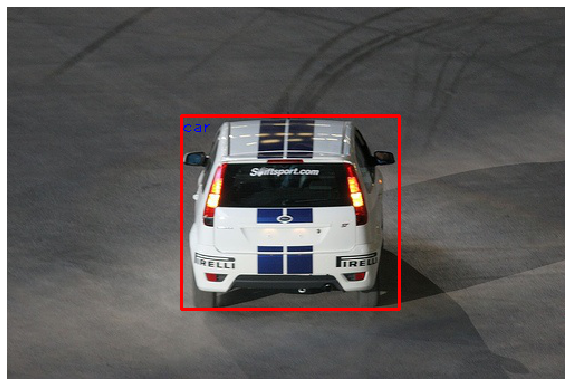

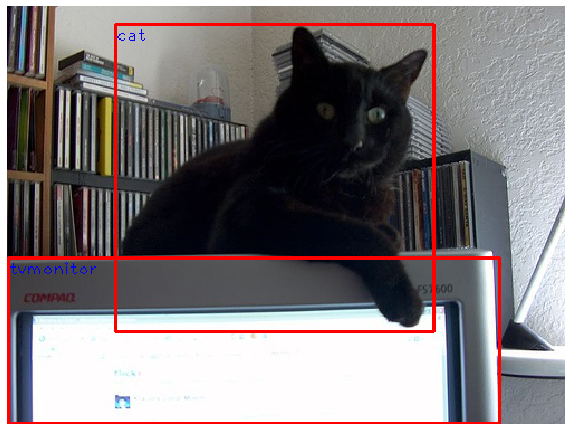

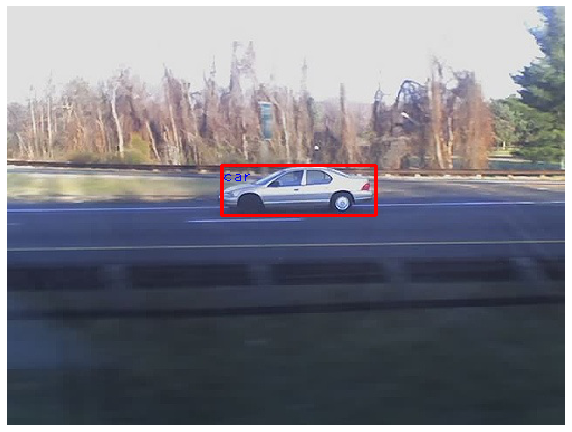

In [22]:
# default examples for visualization
reset_seed(0) # random.seed(0), torch.manual_seed(0)
batch_size = 3
sampled_idx = torch.linspace(0, len(train_dataset)-1, steps=batch_size).long()

# get the size of each image first
h_list = []
w_list = []
img_list = []
MAX_NUM_BBOX = 40 # maximum number of bounding boxes per image
# (B, MAX, 5)
box_list = torch.LongTensor(batch_size, MAX_NUM_BBOX, 5).fill_(-1) # PADDED GT boxes

for idx, i in enumerate(sampled_idx):
  # hack to get the original image so we don't have to load from local again...
  img, ann = train_dataset[i]
  img_list.append(img)

  # all boxes per image
  all_bbox = ann['annotation']['object'] # list of dictionary
  if type(all_bbox) == dict: # in case of dataset inconsistency
    all_bbox = [all_bbox]
  
  for bbox_idx, bbox in enumerate(all_bbox):
    box_list[idx][bbox_idx] = torch.LongTensor([int(bbox['bndbox']['xmin']), int(bbox['bndbox']['ymin']),
                                                int(bbox['bndbox']['xmax']), int(bbox['bndbox']['ymax']),
                                                int(class_to_idx[bbox['name']])])
  
  h_list.append(img.height) # img.size[1]
  w_list.append(img.width) # img.size[0]

w_list = torch.as_tensor(w_list).float().cuda() # (B, )
h_list = torch.as_tensor(h_list).float().cuda() # (B, )
box_list = torch.as_tensor(box_list).float().cuda() # (B, max, 5)
resized_box_list = coord_trans(box_list, w_list, h_list, mode='p2a')

for i in range(len(img_list)):
  num_valid_bbox = sum([1 if j!= -1 else 0 for j in box_list[i][:, 0]])
  detection_visualizer(img_list[i], idx_to_class, box_list[i][:num_valid_bbox])




# Detector Backbone Network
Here, we use [MobileNet v2](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/) for image feature extraction. The code is based on Assignment 4-2. The function is included in a5_helper and can be seen below. 

Now, let's see what's inside MobileNet v2. Assume we have a 3x224x224 image input.

In [24]:
test = nn.AvgPool2d(math.ceil(224 / 32.))
a = torch.zeros((5, 3, 7, 7))
test(a).shape

torch.Size([5, 3, 1, 1])

In [25]:
a = a.squeeze(-1)
a.shape

torch.Size([5, 3, 7, 7])

In [26]:
from torchsummary import summary

class FeatureExtractor(nn.Module):
  """
  Image feature extraction with MobileNet
  """
  def __init__(self, reshape_size=224, pooling=False, verbose=False):
    super().__init__()
    self.mobilenet = torchvision.models.mobilenet_v2(pretrained=True)
    # Exclude the last layer
    self.mobilenet = nn.Sequential(*list(self.mobilenet.children())[:-1])

    # Add pooling layer
    if pooling:
      self.mobilenet.add_module("LastAvgPool", nn.AvgPool2d(math.ceil(reshape_size/32.)))
    
    # Fine tune all parameters
    for name, param in self.mobilenet.named_parameters():
      param.requires_grad = True
    
    # Print the network information
    if verbose:
      summary(self.mobilenet.cuda(), input_size=(3, reshape_size, reshape_size))

  def forward(self, img, verbose=False):
    """
    Input:
      - img: total imgs with shape (N, 3, 224, 224), here, N is the total number of images.
    
    Output:
      - feat: extracted features with shape (N, 1280) (pooled) or (N, 1280, 7, 7)
    """

    num_img = img.shape[0]

    img_prepro = img
    process_batch = 500
    num_batch = math.ceil(num_img / process_batch)

    feat = []
    for b in range(num_batch):
      feat.append(self.mobilenet(img_prepro[b*process_batch:(b+1)*process_batch]).squeeze(-1).squeeze(-1)) # (500, 1280) (pooled)
    
    feat = torch.cat(feat) # (N, 1280)

    if verbose:
      print("Output shape: ", feat.shape)

    return feat

In [27]:
model = FeatureExtractor(pooling=True, verbose=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

# Anchor and Proposal
The concept of *anchor* is introduced in [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf) and later used in numerous later works including [YOLO v2](https://arxiv.org/pdf/1612.08242.pdf). The definition of anchor from the original paper is summarized as follows:






The concept of ***anchor*** is introduced in ***Faster R-CNN*** and later used in numerous later works including ***YOLO v2***. 

The ***definition of anchor*** from the original paper is summarized as follows:

After passing the input image through the backbone network, we have a ***convolutional feature map*** of shape (C, 7, 7), which we interpret as a 7x7 grid of C-dimensional features. ***At each point / position in this grid***, we consider a set of A anchor boxes of different sizes and shapes; For each anchor box, we classify it as either an object or background box. The total number of anchor boxes that we consider for the entire input image is (A, 7, 7); 

We predict ***classification scores*** of this shape by **applying a sequence of convolutional layers** to the backbone features. We slide ***a small network*** (e.g. 3x3 conv layer) over the CNN activation feature map. We call this 3x3 conv as a sliding window. ***At each sliding-window location*** (i.e. centered at each position of the 7x7 activation cell), we ***simultaneously predict multiple*** region proposals, where the number of proposals for each location is denoted as A=9.

Later, we will have:


1.   An **object proposal layer** output A-D scores that estimate p**robability of object** for each proposal;
2.   A **bounding box regression layer** to produce 4A-D outputs encoding **the coordinates** of A boxes;
3.   A **region classification layer** to produce 20-D outputs indicating the **probability of being each object category** (shared by all A anchors).

The A proposals are parameterized **relative to** A reference boxes, which we call **anchors**.

An anchor is centered at the sliding window in question, and is associated with a shape (e.g., 1x1, 3x3, 5x5). The list of anchor shapes are provided next.









## Anchor shapes

At **each spatial position** of the 7x7 backbone features, we consider a set of A anchor boxes. **Different spatial position all use anchors of the same shape**.

The **shapes** of the anchor boxes are a **hyperparameter**. We will provide the anchor shapes for you, and we will **re-use the same anchor shapes** for both A5-1 and A5-2. 

In some papers (e.g. YOLO v2), the anchor shapes are determined in a data-driven way by **clustering the set of ground-truth box sizes**, but for simplicity, we will not use that approach in this assignment.

**Note** that anchors could be much larger than the 3x3 sliding window (e.g., 5x5), since the receptive field of activation cell on the original image could be large.

In [28]:
# Declare variables for anchor priors, a Ax2 Tensor where A is the number of anchors.
# Hand-picked, same as our two-stage detector.

# (A, 2), here A=9
anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]]).float().cuda()

print(anchor_list)
print(anchor_list.shape)

tensor([[1., 1.],
        [2., 2.],
        [3., 3.],
        [4., 4.],
        [5., 5.],
        [2., 3.],
        [3., 2.],
        [3., 5.],
        [5., 3.]], device='cuda:0')
torch.Size([9, 2])


## Activation Grid Generator

In order to place anchors centered at each position of the 7x7 grid of backbone features, we need to know the **spatial position of the center of each cell** in the **7x7 grid of features**.

The function ```GenerateGrid()``` will compute these **center coordinates** for us.

In [29]:
def GenerateGrid(batch_size, w_amap=7, h_amap=7, dtype=torch.float32, device='cuda'):
  """
  Return a grid cell given a batch size (center coordinates)

  Inputs:
    - batch_size: B
    - w_amap: or W', width of the activation map (number of grids in the horizontal dimension)
    - h_amap: or H', height of the activation map (number of grids in the vertical dimension)
    - W' and H' are always 7 in our case
  
  Outputs:
    - grid: A float32 tensor of shape (B, H', W', 2) giving the (x, y) coordinates of the centers
    of each feature for a feature map of shape (B, D, H', W')
  """

  w_coord = (torch.arange(0, w_amap, dtype=dtype, device=device) + 0.5).unsqueeze(0).repeat(h_amap, 1) # (W') -> (1, W') -> (H', W')
  h_coord = (torch.arange(0, h_amap, dtype=dtype, device=device) + 0.5).unsqueeze(1).repeat(1, w_amap) # (H') -> (H', 1) -> (H', W')

  grid = torch.stack((w_coord, h_coord), dim=-1) # (H', W', 2)
  grid = grid.unsqueeze(0).repeat(batch_size, 1, 1, 1) # (H', W', 2) -> (1, H', W', 2) -> (B', H', W', 2)

  return grid


In [ ]:
a = (torch.arange(0, 7) + 0.5).unsqueeze(0).repeat(7, 1)
b = (torch.arange(0, 7) + 0.5).unsqueeze(1).repeat(1, 7)
a

tensor([[0.5000, 1.5000, 2.5000, 3.5000, 4.5000, 5.5000, 6.5000],
        [0.5000, 1.5000, 2.5000, 3.5000, 4.5000, 5.5000, 6.5000],
        [0.5000, 1.5000, 2.5000, 3.5000, 4.5000, 5.5000, 6.5000],
        [0.5000, 1.5000, 2.5000, 3.5000, 4.5000, 5.5000, 6.5000],
        [0.5000, 1.5000, 2.5000, 3.5000, 4.5000, 5.5000, 6.5000],
        [0.5000, 1.5000, 2.5000, 3.5000, 4.5000, 5.5000, 6.5000],
        [0.5000, 1.5000, 2.5000, 3.5000, 4.5000, 5.5000, 6.5000]])

In [ ]:
b

tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000, 1.5000],
        [2.5000, 2.5000, 2.5000, 2.5000, 2.5000, 2.5000, 2.5000],
        [3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000, 3.5000],
        [4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000, 4.5000],
        [5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000, 5.5000],
        [6.5000, 6.5000, 6.5000, 6.5000, 6.5000, 6.5000, 6.5000]])

In [ ]:
torch.stack((a, b), dim=-1)

tensor([[[0.5000, 0.5000],
         [1.5000, 0.5000],
         [2.5000, 0.5000],
         [3.5000, 0.5000],
         [4.5000, 0.5000],
         [5.5000, 0.5000],
         [6.5000, 0.5000]],

        [[0.5000, 1.5000],
         [1.5000, 1.5000],
         [2.5000, 1.5000],
         [3.5000, 1.5000],
         [4.5000, 1.5000],
         [5.5000, 1.5000],
         [6.5000, 1.5000]],

        [[0.5000, 2.5000],
         [1.5000, 2.5000],
         [2.5000, 2.5000],
         [3.5000, 2.5000],
         [4.5000, 2.5000],
         [5.5000, 2.5000],
         [6.5000, 2.5000]],

        [[0.5000, 3.5000],
         [1.5000, 3.5000],
         [2.5000, 3.5000],
         [3.5000, 3.5000],
         [4.5000, 3.5000],
         [5.5000, 3.5000],
         [6.5000, 3.5000]],

        [[0.5000, 4.5000],
         [1.5000, 4.5000],
         [2.5000, 4.5000],
         [3.5000, 4.5000],
         [4.5000, 4.5000],
         [5.5000, 4.5000],
         [6.5000, 4.5000]],

        [[0.5000, 5.5000],
         [1.5000, 

We now visualize its output

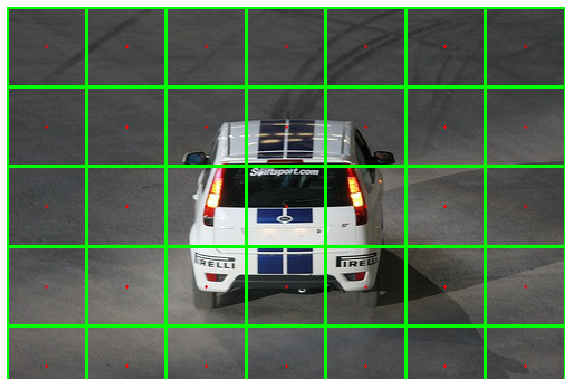

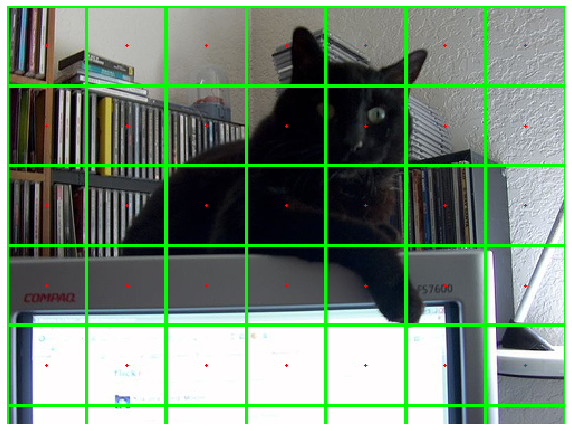

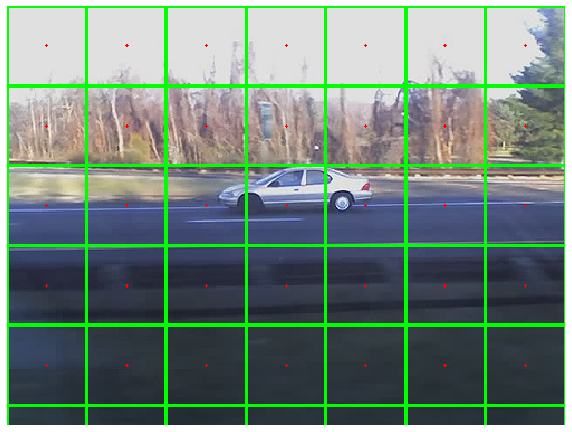

In [30]:
# visualization
# simply create an activation grid where the cells are in green and the centers are in red
# you should see the entire image divided by a 7x7 grid, with not gaps on the edges.

grid_list = GenerateGrid(w_list.shape[0]) # (3, 7, 7, 2)

center = torch.cat((grid_list, grid_list), dim=-1) # (3, 7, 7, 4)
grid_cell = center.clone() # (3, 7, 7, 4)

grid_cell[:, :, :, [0, 1]] -= 1. / 2. # top-left corner coordinates
grid_cell[:, :, :, [2, 3]] += 1. / 2. # bottom-right corner coordinates

# Transfer the center coordinates and grid cell coordinates
# from activation map coordinate system to the original image coordinate system FOR VISUALIZATION
center = coord_trans(center, w_list, h_list, mode='a2p') # (3, 7, 7, 4)
grid_cell = coord_trans(grid_cell, w_list, h_list, mode='a2p') # (3, 7, 7, 4)

'''
for img, anc, grid in zip(img_list, center, grid_cell):
  detection_visualizer(img, idx_to_class, anc.reshape(-1, 4), grid.reshape(-1, 4))
'''
for i, img in enumerate(img_list):
  detection_visualizer(img, idx_to_class, center[i].reshape(-1, 4), grid_cell[i].reshape(-1, 4))






## Anchor Generator


At this point, we have defined the **spatial size of anchors** that we consider at each grid point, and we have computed the **center of each grid point**.

Now, we combine these two pieces of information to **compute the positions of all anchor boxes for the entire image.**

We denote the anchor coordinates as $(x_{tl}^{a}, y_{tl}^{a}, x_{br}^{a}, y_{br}^{a})$, indicating the coordinates of the top-left corner and bottom-right corner accordingly.

The following function `GenerateAnchor()` returns all the anchors given the anchor shapes and the grid cell.
**Note that the center of an anchor overlaps a grid cell center**.

Run the following to check your implementation. You should see errors on the order of 1e-8 or less.

In [ ]:
anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3], [3, 2], [3, 5], [5, 3]]).float().cuda()
grid_list = GenerateGrid(w_list.shape[0])

In [ ]:
grid_list.dtype, grid_list.shape, grid_list.device

(torch.float32, torch.Size([3, 7, 7, 2]), device(type='cuda', index=0))

In [31]:
def GenerateAnchor(anc, grid):
  """
  Anchor generator.

  Inputs:
  - anc: Tensor of shape (A, 2) giving the shapes of anchor boxes to consider at
    each point in the grid. anc[a] = (w, h) gives the width and height of the
    a'th anchor shape.
  - grid: Tensor of shape (B, H', W', 2) giving the (x, y) coordinates of the
    center of each feature from the backbone feature map. This is the tensor
    returned from GenerateGrid.
  
  Outputs:
  - anchors: Tensor of shape (B, A, H', W', 4) giving the positions of all
    anchor boxes for the entire image. anchors[b, a, h, w] is an anchor box
    centered at grid[b, h, w], whose shape is given by anc[a]; we parameterize
    boxes as anchors[b, a, h, w] = (x_tl, y_tl, x_br, y_br), where (x_tl, y_tl)
    and (x_br, y_br) give the xy coordinates of the top-left and bottom-right
    corners of the box.
  """
  anchors = None
  ##############################################################################
  # TODO: Given a set of anchor shapes and a grid cell on the activation map,  #
  # generate all the anchor coordinates for each image. Support batch input.   #
  ##############################################################################
  # Replace "pass" statement with your code
  
  # number of anchors per grid cell
  A = anc.shape[0]
  B, H_prime, W_prime, _ = grid.shape # batch_size
  
  # initialize anchors (batched)
  anchors = torch.zeros((B, A, H_prime, W_prime, 4)).float().cuda() 
  for i in range(B):
    for j in range(A):
      anchors[i, j, :, :, [0, 1]] =  grid[i] - 0.5 * anc[j].unsqueeze(0).unsqueeze(0) # (H', W', 2) + (1, 1, 2) = (H', W', 2)
      anchors[i, j, :, :, [2, 3]] =  grid[i] + 0.5 * anc[j].unsqueeze(0).unsqueeze(0)

  ##############################################################################
  #                               END OF YOUR CODE                             #
  ##############################################################################

  return anchors

In [32]:
#from single_stage_detector import GenerateAnchor

# sanity check
anc_list = GenerateAnchor(anchor_list, grid_list)
assert anc_list.shape == torch.Size([3, 9, 7, 7, 4]), 'shape mismatch!'

expected_anc_list_mean = torch.tensor([[-1.25000000, -0.87500000,  2.25000000,  1.87500000],
                                       [ 1.75000000, -0.87500000,  5.25000000,  1.87500000],
                                       [ 4.75000000, -0.87500000,  8.25000000,  1.87500000],
                                       [-1.25000000,  1.12500000,  2.25000000,  3.87500000],
                                       [ 1.75000000,  1.12500000,  5.25000000,  3.87500000],
                                       [ 4.75000000,  1.12500000,  8.25000000,  3.87500000],
                                       [-1.25000000,  3.12500000,  2.25000000,  5.87500000],
                                       [ 1.75000000,  3.12500000,  5.25000000,  5.87500000],
                                       [ 4.75000000,  3.12500000,  8.25000000,  5.87500000],
                                       [-1.25000000,  5.12500000,  2.25000000,  7.87500000],
                                       [ 1.75000000,  5.12500000,  5.25000000,  7.87500000],
                                       [ 4.75000000,  5.12500000,  8.25000000,  7.87500000]], dtype=torch.float32, device='cuda')
print('rel error: ', rel_error(expected_anc_list_mean, anc_list[0, [1,3,6,8], ::2, ::3, :].view(-1, 12, 4).mean(0)))

rel error:  0.0


In [ ]:
anc_list[0, [1,3,6,8], ::2, ::3, :].view(-1, 12, 4).mean(0)

tensor([[-1.2500, -0.8750,  2.2500,  1.8750],
        [ 1.7500, -0.8750,  5.2500,  1.8750],
        [ 4.7500, -0.8750,  8.2500,  1.8750],
        [-1.2500,  1.1250,  2.2500,  3.8750],
        [ 1.7500,  1.1250,  5.2500,  3.8750],
        [ 4.7500,  1.1250,  8.2500,  3.8750],
        [-1.2500,  3.1250,  2.2500,  5.8750],
        [ 1.7500,  3.1250,  5.2500,  5.8750],
        [ 4.7500,  3.1250,  8.2500,  5.8750],
        [-1.2500,  5.1250,  2.2500,  7.8750],
        [ 1.7500,  5.1250,  5.2500,  7.8750],
        [ 4.7500,  5.1250,  8.2500,  7.8750]], device='cuda:0')

In [ ]:
grid_list.shape

torch.Size([3, 7, 7, 2])

In [ ]:
grid_list[:, 3:4, 3:4]

tensor([[[[3.5000, 3.5000]]],


        [[[3.5000, 3.5000]]],


        [[[3.5000, 3.5000]]]], device='cuda:0')

In [ ]:
anchor_list, anchor_list.shape

(tensor([[1., 1.],
         [2., 2.],
         [3., 3.],
         [4., 4.],
         [5., 5.],
         [2., 3.],
         [3., 2.],
         [3., 5.],
         [5., 3.]], device='cuda:0'), torch.Size([9, 2]))

In [ ]:
grid_list.shape

torch.Size([3, 7, 7, 2])

In [ ]:
help(detection_visualizer)

Help on function detection_visualizer in module __main__:

detection_visualizer(img, idx_to_class, bbox=None, pred=None)
    Data visualizer on the original image.
    
    Support both GT bbox input and proposal input.
    
    Input:
      - img: PIL image input;
      - idx_to_class: Mapping from the index (0-19) to the class name
      - bbox: GT bbox (in red, optional), a tensor of shape (N, 5), at least with shape (N, 4)
        where N is the number of GT boxes
              5 indicates (x_tl, y_tl, x_br, y_br, class_idx)
      - pred: predicted bbox (in green, optional), a tensor of shape (N', 6), at least with shape (N, 4)
        where N' is the number of predicted boxes
              6 indicates (x_tl, y_tl, x_br, y_br, class_idx, object confidence score)



********************************************************************************
All nine anchors should be exactly centered:
Shape of anc_list: torch.Size([3, 9, 1, 1, 4])
torch.Size([9, 1, 1, 4])


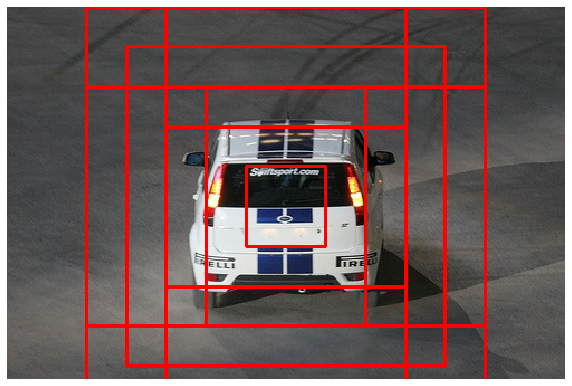

torch.Size([9, 1, 1, 4])


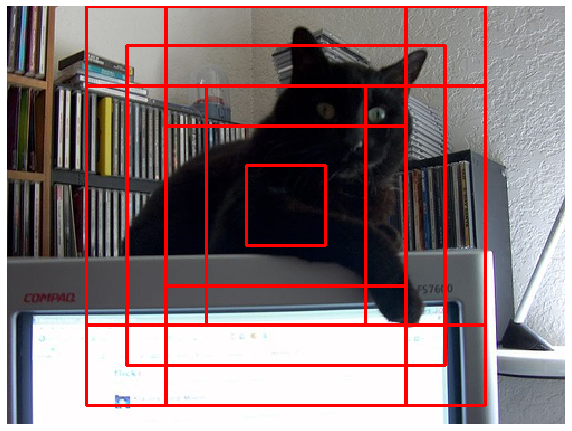

torch.Size([9, 1, 1, 4])


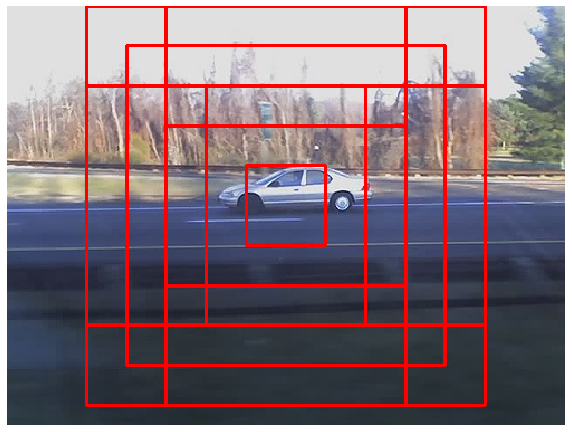

********************************************************************************
All anchors of the image (cluttered):
Shape of anc_list: torch.Size([3, 9, 7, 7, 4])
torch.Size([9, 7, 7, 4])


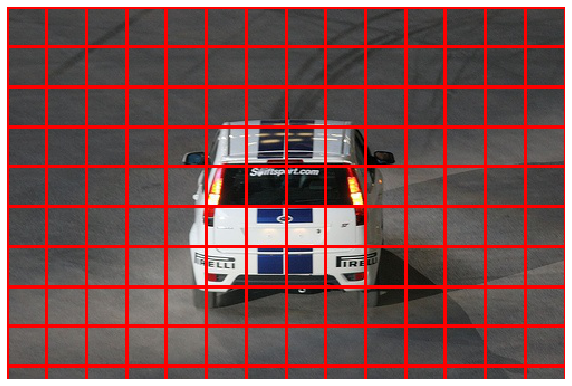

torch.Size([9, 7, 7, 4])


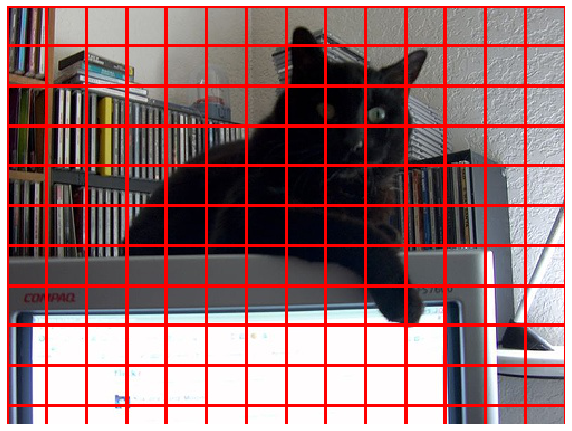

torch.Size([9, 7, 7, 4])


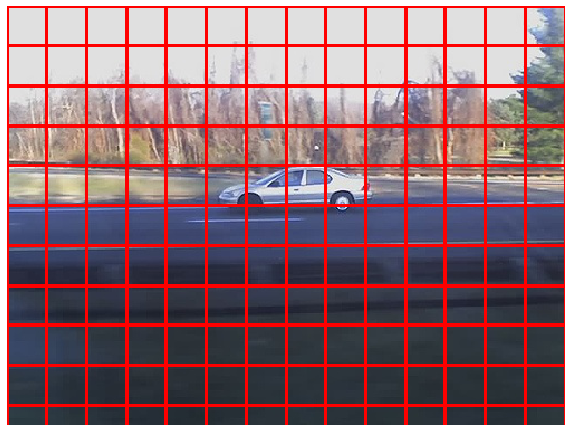

In [33]:
# visualization
print('*'*80)
print('All nine anchors should be exactly centered:')
anc_list = GenerateAnchor(anchor_list, grid_list[:, 2:3, 3:4]) # (3, 9, 1, 1, 4)
print(f'Shape of anc_list: {anc_list.shape}')

for img, anc in zip(img_list, coord_trans(anc_list, w_list, h_list)):
  print(anc.shape)
  detection_visualizer(img, idx_to_class, anc.reshape(-1, 4))

print('*'*80)
print('All anchors of the image (cluttered):')
anc_list = GenerateAnchor(anchor_list, grid_list) # all anchors (3, 9, 7, 7, 4)
print(f'Shape of anc_list: {anc_list.shape}')
for img, anc in zip(img_list, coord_trans(anc_list, w_list, h_list)):
  print(anc.shape)
  detection_visualizer(img, idx_to_class, anc.reshape(-1, 4))

In [ ]:
anchor_list.shape, grid_list.shape

(torch.Size([9, 2]), torch.Size([3, 7, 7, 2]))

In [ ]:
help(GenerateAnchor)

Help on function GenerateAnchor in module __main__:

GenerateAnchor(anc, grid)
    Anchor generator.
    
    Inputs:
    - anc: Tensor of shape (A, 2) giving the shapes of anchor boxes to consider at
      each point in the grid. anc[a] = (w, h) gives the width and height of the
      a'th anchor shape.
    - grid: Tensor of shape (B, H', W', 2) giving the (x, y) coordinates of the
      center of each feature from the backbone feature map. This is the tensor
      returned from GenerateGrid.
    
    Outputs:
    - anchors: Tensor of shape (B, A, H', W', 4) giving the positions of all
      anchor boxes for the entire image. anchors[b, a, h, w] is an anchor box
      centered at grid[b, h, w], whose shape is given by anc[a]; we parameterize
      boxes as anchors[b, a, h, w] = (x_tl, y_tl, x_br, y_br), where (x_tl, y_tl)
      and (x_br, y_br) give the xy coordinates of the top-left and bottom-right
      corners of the box.



## Proposal Generator
If we only use anchors to propose object locations, we can only cover 9x7x7=441 regions in the image. 

**What if an object does not fall into any of the regions?**

Hence, in the recent literatures (e.g., [Fast R-CNN](https://arxiv.org/pdf/1504.08083.pdf)), the detector predicts **transformations** that convert **anchor boxes** into region proposals.

So far, we have represented anchors boxes by the coordinates of their top-left and bottom-right corners $(x_{tl}^a, y_{tl}^a, x_{br}^a, y_{br}^a)$. When **converting anchors to proposals**, it will be **more convenient** to parameterize boxes by the xy coordinate of their **center**, and their **width and height**: **$(x_c^a,y_c^a,w^a,h^a)$**.

Now, consider an anchor box with center, width and height $(x_c^a,y_c^a,w^a,h^a)$.
The network will predict a **transformation** $(t^x, t^y, t^w, t^h)$; applying this transformation to the anchor yields a **region proposal** with center, width and height $(x_c^p,y_c^p,w^p,h^p)$.

YOLO and Faster R-CNN use **slightly different formulas** to convert **anchors** into **proposals**. Here you need to implement both formulations.

### YOLO
For YOLO, we assume that $t^x$ and $t^y$ are both in the **range** $-0.5\leq t^x,t^y\leq 0.5$, while $t^w$ and $t^h$ are real numbers in the range $(-\infty, \infty)$. Then we have:
- $x_c^p = x_c^a + t^x$
- $y_c^p = y_c^a + t^y$
- $w^p = w^a exp(t^w)$
- $h^p = h^a exp(t^h)$

### Faster R-CNN
For Faster R-CNN, we assume that all transformation parameters $t^x, t^y, t^w, t^h$ are real numbers in the range $(-\infty, \infty)$. Then we have:
- $x_c^p = x_c^a + t^xw^a$
- $y_c^p = y_c^a + t^yh^a$
- $w^p = w^a exp(t^w)$
- $h^p = h^a exp(t^h)$


### Training
During training, we compute the **ground-truth transformation** $(\hat{t^x}, \hat{t^y}, \hat{t^w}, \hat{t^h})$ that would transform the anchor box $(x_c^a,y_c^a,w^a,h^a)$ into the ground-truth box $(x_c^{gt},y_c^{gt},w^{gt},h^{gt})$. 

We then apply a **regression loss** that **penalizes differences** between the **predicted transform** $(t^x, t^y, t^w, t^h)$ and the **ground-truth transform**.


Run the following to check your implementation. You should see errors on the order of 1e-7 or less.


In [34]:
def GenerateProposal(anchors, offsets, method='YOLO'):
  """
  Proposal generator.

  Inputs:
  - anchors: Anchor boxes, of shape (B, A, H', W', 4). Anchors are represented
    by the coordinates of their top-left and bottom-right corners.
  - offsets: Transformations of shape (B, A, H', W', 4) that will be used to
    convert anchor boxes into region proposals. The transformation
    offsets[b, a, h, w] = (tx, ty, tw, th) will be applied to the anchor
    anchors[b, a, h, w]. For YOLO, assume that tx and ty are in the range
    (-0.5, 0.5).
  - method: Which transformation formula to use, either 'YOLO' or 'FasterRCNN'
  
  Outputs:
  - proposals: Region proposals of shape (B, A, H', W', 4), represented by the
    coordinates of their top-left and bottom-right corners. Applying the
    transform offsets[b, a, h, w] to the anchor [b, a, h, w] should give the
    proposal proposals[b, a, h, w].
  
  """
  assert(method in ['YOLO', 'FasterRCNN'])
  proposals = None
  ##############################################################################
  # TODO: Given anchor coordinates and the proposed offset for each anchor,    #
  # compute the proposal coordinates using the transformation formulas above.  #
  ##############################################################################
  # Replace "pass" statement with your code

  # Initialization 
  anchors_transfered = torch.zeros_like(anchors)

  # Transfer from (x_tl, y_tl, x_br, y_br) to (x_c, y_c, w, h)
  anchors_transfered[..., [0, 1]] = (anchors[..., [0, 1]] + anchors[..., [2, 3]]) / 2 # x_c
  anchors_transfered[..., [2, 3]] = (anchors[..., [2, 3]] - anchors[..., [0, 1]]) # w

  if method == 'YOLO':
    anchors_transfered[..., [0, 1]] += offsets[..., [0, 1]]
  
  else:
    anchors_transfered[..., [0, 1]] += offsets[..., [0, 1]] * anchors_transfered[..., [2, 3]]

  anchors_transfered[..., [2, 3]] *= torch.exp(offsets[..., [2, 3]])

  proposals = torch.zeros_like(anchors)
  # Transfer from (x_c, y_c, w, h) to (x_tl, y_tl, x_br, y_br)
  proposals[..., [0, 1]] = anchors_transfered[..., [0, 1]] - anchors_transfered[..., [2, 3]] * 0.5
  proposals[..., [2, 3]] = anchors_transfered[..., [0, 1]] + anchors_transfered[..., [2, 3]] * 0.5

  ##############################################################################
  #                               END OF YOUR CODE                             #
  ##############################################################################

  return proposals

In [35]:
#from single_stage_detector import GenerateProposal

print('-' * 80)
print('Sanity check for YOLO.')
yolo_offset_list = torch.cat([torch.ones_like(anc_list[:, :, :, :, 0:2]).fill_(.5), torch.ones_like(anc_list[:, :, :, :, 2:4])], dim=-1)
yolo_proposal_list = GenerateProposal(anc_list, yolo_offset_list, 'YOLO') # no scaling

print('1. Center moved by ~0.5 cell')
print('rel error: ', rel_error(anc_list[0, 0, 0, :, 0:2] + (anc_list[0, 0, 0, :, 2:4] - anc_list[0, 0, 0, :, 0:2])/2.0 + 0.5, \
                               (yolo_proposal_list[0, 0, 0, :, 0:2] + (yolo_proposal_list[0, 0, 0, :, 2:4] - yolo_proposal_list[0, 0, 0, :, 0:2]) / 2.0)))

print('2. w/h changed by e')
print('rel error: ', rel_error((anc_list[0, 0, 0, :, 2:4] - anc_list[0, 0, 0, :, 0:2]) * torch.exp(torch.ones_like(anc_list[0, 0, 0, :, 0:2])), \
      (yolo_proposal_list[0, 0, 0, :, 2:4] - yolo_proposal_list[0, 0, 0, :, 0:2])))


print('-' * 80)
print('Sanity check for FasterRCNN.')
rcnn_offset_list = torch.ones_like(anc_list)
rcnn_proposal_list = GenerateProposal(anc_list, rcnn_offset_list, 'FasterRCNN')

print('1. x/y shifted by wh')
print('rel error: ', rel_error(anc_list[0, 0, 0, :, 0:2] + (anc_list[0, 0, 0, :, 2:4] - anc_list[0, 0, 0, :, 0:2]) * 3.0 /2.0, \
      (rcnn_proposal_list[0, 0, 0, :, 0:2] + (rcnn_proposal_list[0, 0, 0, :, 2:4] - rcnn_proposal_list[0, 0, 0, :, 0:2]) / 2.0)))

print('2. w/h should changed by e')
print('rel error: ', rel_error((anc_list[0, 0, 0, :, 2:4] - anc_list[0, 0, 0, :, 0:2]) * torch.exp(torch.ones_like(anc_list[0, 0, 0, :, 0:2])), \
      (rcnn_proposal_list[0, 0, 0, :, 2:4] - rcnn_proposal_list[0, 0, 0, :, 0:2])))

--------------------------------------------------------------------------------
Sanity check for YOLO.
1. Center moved by ~0.5 cell
rel error:  0.0
2. w/h changed by e
rel error:  8.770929630831571e-08
--------------------------------------------------------------------------------
Sanity check for FasterRCNN.
1. x/y shifted by wh
rel error:  0.0
2. w/h should changed by e
rel error:  8.770929630831571e-08


As an additional sanity check, we visualize an anchor (in red) and the corresponding proposal (in green) that results from applying the transform $(0.5, 0.5, 0, 0)$. The proposal should shift down and to the right (when using the YOLO formulation).

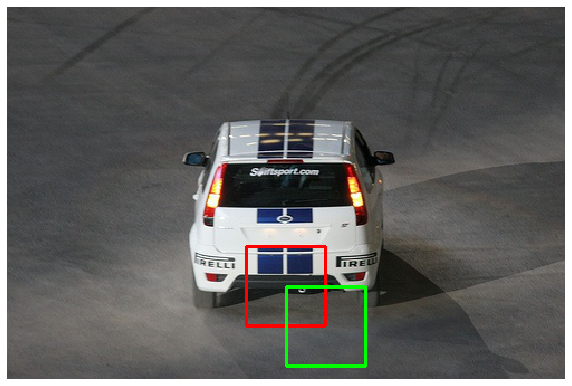

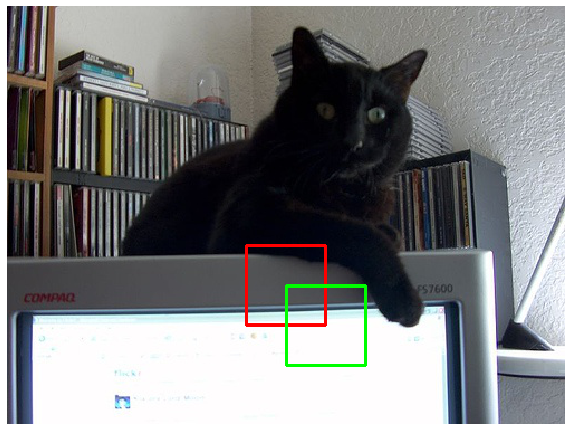

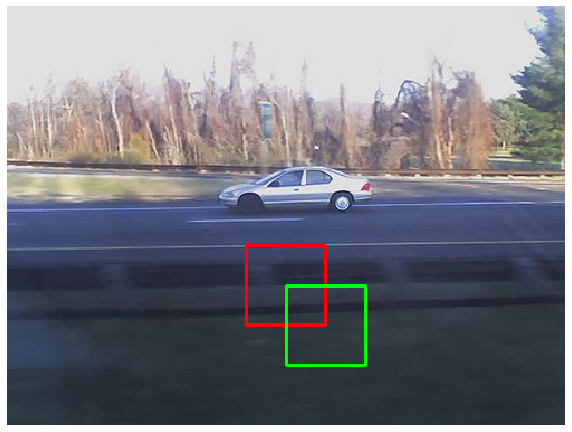

In [36]:
yolo_offset_list = torch.cat([torch.ones_like(anc_list[:, :, :, :, 0:2]).fill_(.5), torch.zeros_like(anc_list[:, :, :, :, 2:4])], dim=-1)
yolo_proposal_list = GenerateProposal(anc_list, yolo_offset_list, 'YOLO')

for img, anc, prop in zip(img_list, coord_trans(anc_list[:, 0:1, 3:4, 3:4, :], w_list, h_list), \
                          coord_trans(yolo_proposal_list[:, 0:1, 3:4, 3:4, :], w_list, h_list)):
  detection_visualizer(img, idx_to_class, anc.reshape(-1, 4), prop.reshape(-1, 4))

Next we visualize the effect of applying the transform $(0, 0, 1, 1)$ (with the YOLO formula) to the same anchor box (in red). Now the proposal (in green) should have the same center as the anchor, but the proposal should be larger.

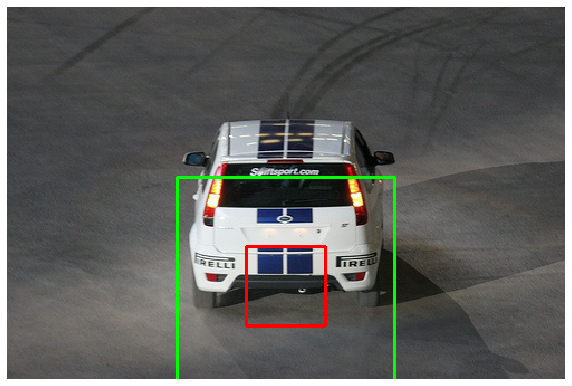

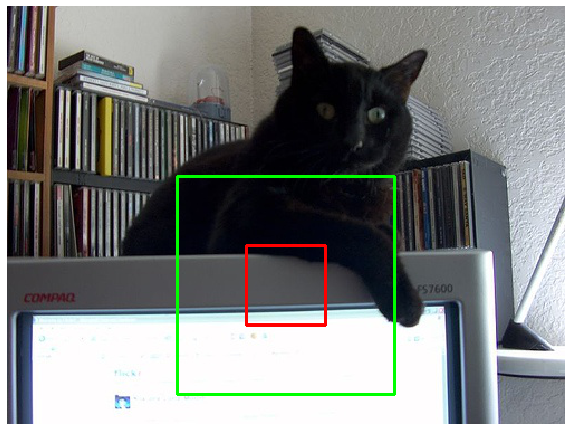

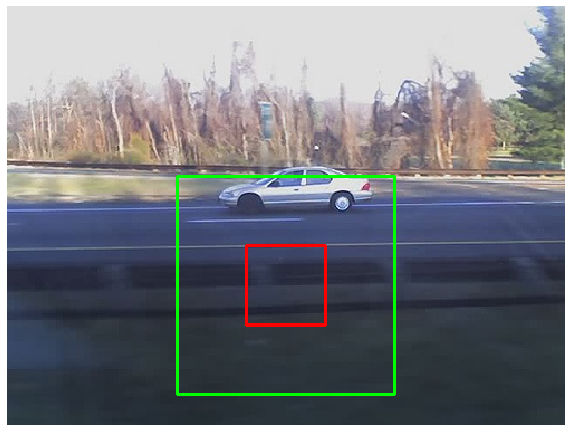

In [37]:
yolo_offset_list = torch.cat([torch.zeros_like(anc_list[:, :, :, :, 0:2]), torch.ones_like(anc_list[:, :, :, :, 2:4]).fill_(1.)], dim=-1)
yolo_proposal_list = GenerateProposal(anc_list, yolo_offset_list, 'YOLO')

for img, anc, prop in zip(img_list, coord_trans(anc_list[:, 0:1, 3:4, 3:4, :], w_list, h_list), \
                          coord_trans(yolo_proposal_list[:, 0:1, 3:4, 3:4, :], w_list, h_list)):
  detection_visualizer(img, idx_to_class, anc.reshape(-1, 4), prop.reshape(-1, 4))

Next to sanity-check our implementation of the Faster R-CNN transformation formulas, we visualize the effect of applying the transform $(1, 1, 0, 0)$ to the same anchor (in red). The proposal (in green) should shift down and to the right by an amount equal to the size of the anchor.

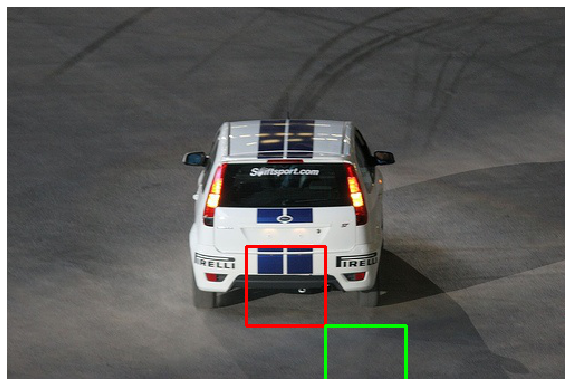

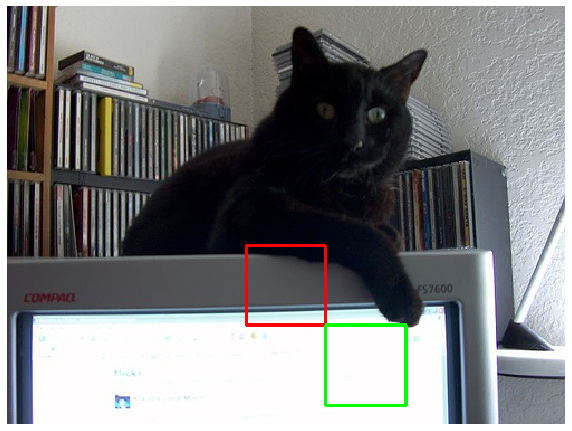

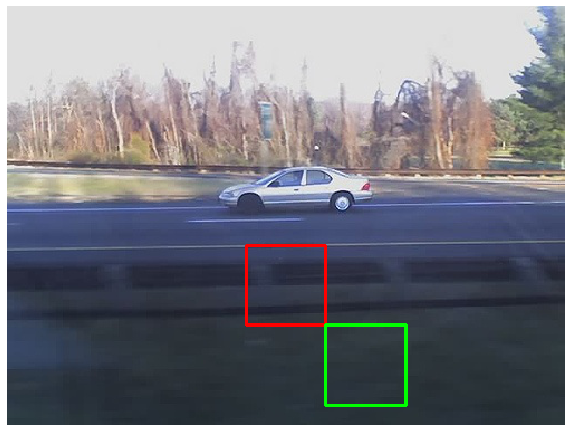

In [38]:
# visualization (shift by wh, Faster R-CNN)
# anchors in red and proposals in green
rcnn_offset_list = torch.cat([torch.ones_like(anc_list[:, :, :, :, 0:2]), torch.zeros_like(anc_list[:, :, :, :, 2:4])], dim=-1)
rcnn_proposal_list = GenerateProposal(anc_list, rcnn_offset_list, 'FasterRCNN')

for img, anc, prop in zip(img_list, coord_trans(anc_list[:, 0:1, 3:4, 3:4, :], w_list, h_list), \
                          coord_trans(rcnn_proposal_list[:, 0:1, 3:4, 3:4, :], w_list, h_list)):
  detection_visualizer(img, idx_to_class, anc.reshape(-1, 4), prop.reshape(-1, 4))

We further check our implementation of the Faster R-CNN transformation formula, and visualize the effect of applying the transformation $(0, 0, 1, 1)$ to the same anchor. Now the proposal (in green) should have the same center as the anchor (in red), but the proposal should be larger by a factor of $e$.

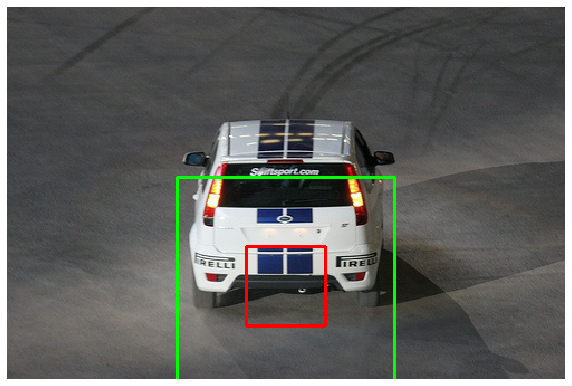

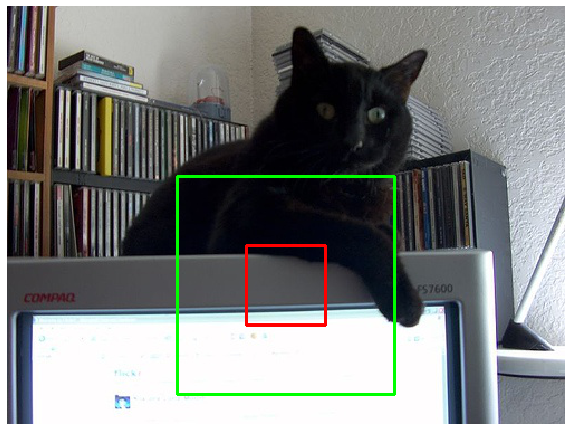

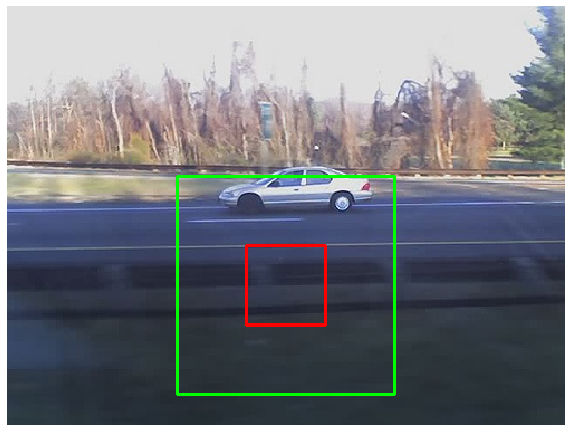

In [39]:
# visualization (no shift and then scale by e, Faster R-CNN)
# anchors in red and proposals in green
rcnn_offset_list = torch.cat([torch.zeros_like(anc_list[:, :, :, :, 0:2]), torch.ones_like(anc_list[:, :, :, :, 2:4]).fill_(1)], dim=-1)
rcnn_proposal_list = GenerateProposal(anc_list, rcnn_offset_list, 'FasterRCNN')

for img, anc, prop in zip(img_list, coord_trans(anc_list[:, 0:1, 3:4, 3:4, :], w_list, h_list), \
                          coord_trans(rcnn_proposal_list[:, 0:1, 3:4, 3:4, :], w_list, h_list)):
  detection_visualizer(img, idx_to_class, anc.reshape(-1, 4), prop.reshape(-1, 4))

# Prediction Networks
This module outputs the prediction scores (see figure below). We have provided the code to determine activated/negative anchors for you, though you need to **implement the IoU function** for it to work. You will also need to **compute the loss function**. 

The loss function consists of three parts:

1. Confidence score regression
2. Bounding box offsets regression
3. Object classication.

![pred_scores](https://miro.medium.com/max/1055/1*YG6heD55fEmZeUKRSlsqlA.png)


Image credit: [towardsdatascience](https://towardsdatascience.com/yolov1-you-only-look-once-object-detection-e1f3ffec8a89). In this example, number of anchor shapes is $A=2$ while we have $A=9$.

## Intersection Over Union (IoU)
The definition of IoU and instructions on how to compute IoU can be found in the lecture slides (p35-39): https://web.eecs.umich.edu/~justincj/slides/eecs498/FA2020/598_FA2020_lecture15.pdf

Run the following to check your implementation. You should see errors on the order of 1e-8 or less.

In [40]:
def IoU(proposals, bboxes):
  """
  Compute Intersection over Union between sets of bounding boxes;

  *** NOTE ***

  We are computing Intersection over Union in the ACTIVATION MAP COORDINATE SYSTEM (NOT the original image coordinate system)

  Inputs:
    - proposals: Proposals of shape (B, A, H', W', 4)

    - bboxes: Ground-truth boxes from the DataLoader of shape (B, N, 5).
      Each grount-truth box is represented as tuple (x_tl, y_tl, x_br, y_br, class).
      If image i has fewer than N boxes, then bboxes[i] will be padded with extra
      rows of -1.
    
  Outputs:
    - iou_mat: IoU matrix of shape (B, A*H'*W', N) where iou_mat[b, i, n] gives
      the IoU between one element of proposals[b] and bboxes[b, n].
  
  For this implementation, you DO NOT need to filter invalid proposals or boxes;
  in particular, you don't need any special handling for bboxes that are padded with -1.
  """
  iou_mat = None
  ##############################################################################
  # TODO: Compute the Intersection over Union (IoU) on proposals and GT boxes. #
  # No need to filter invalid proposals / bboxes (i.e. allow region area <= 0). #
  # However, you need to make sure to 
  # 1. Compute the IoU correctly (it should be 0 in those cases)
  # 2. Ensure your implementation is efficient (no `for` loops)
  # HINT:
  # IoU = Area or Intersection / Area of Union, where
  # Area of Union = Area of Proposal + Area of BBox - Area of Intersection
  # and the Area of Intersection can be computed using the top-left corner and 
  # bottom-right corner of proposal and bbox. THINK ABOUT their relationships.
  ##############################################################################
  # Replcae "pass" statement with your code

  ############################# compute Area of Proposal #######################
  area_of_proposal = torch.zeros_like(proposals[..., 0]) # (B, A, H', W', 1) store the area of proposal
  width_of_proposal = proposals[..., 2] - proposals[..., 0] # (B, A, H', W', 1) store the width of proposal
  height_of_proposal = proposals[..., 3] - proposals[..., 1] # (B, A, H', W', 1) store the height of proposal

  area_of_proposal = width_of_proposal * height_of_proposal # (B, A, H', W', 1) store the height of proposal
  area_of_proposal = area_of_proposal.view(area_of_proposal.shape[0], -1, 1) # (B, A*H'*W', 1)

  ############################# compute Area of BBox ###########################
  area_of_bbox = torch.zeros_like(bboxes[..., 0]) # (B, N, 1) store the area of bbox
  width_of_bbox = bboxes[..., 2] - bboxes[..., 0] # (B, N, 1)
  height_of_bbox = bboxes[..., 3] - bboxes[..., 1] # (B, N, 1)

  area_of_bbox = width_of_bbox * height_of_bbox # (B, N, 1)
  area_of_bbox = area_of_bbox.squeeze(-1).unsqueeze(1) # (B, N, 1) -> (B, N) -> (B, 1, N)

  # compute Area of Union (haven't subtract the Area of Intersection)
  area_of_union = area_of_proposal + area_of_bbox # (B, A*H'*W', 1) + (B, 1, N) -> (B, A*H'*W', N)

  ########################### compute Area of Intersection #######################
  area_of_intersec = torch.zeros_like(area_of_union) # (B, A*H'*W', N)

  proposals = proposals.view(proposals.shape[0], -1, proposals.shape[-1]).unsqueeze(2) # (B, A, H', W', 4) -> (B, A*H'*W', 4) -> (B, A*H'*W', 1, 4)
  bboxes = bboxes.unsqueeze(1) # (B, N, 5) -> (B, 1, N, 5)

  # top-left coordinates of intersection region
  intersec_tl_coords = torch.maximum(proposals[..., [0, 1]], bboxes[..., [0, 1]]) # (B, A*H'*W', N, 2)
  # bottom-right coordinates of intersection region
  # Here the bottom-right coordinates of the intersection region will be (-1., -1.) if bbox is invalid
  intersec_br_coords = torch.minimum(proposals[..., [2, 3]], bboxes[..., [2, 3]]) # (B, A*H'*W', N, 2)
  # width and height of intersection region
  intersec_wh = intersec_br_coords - intersec_tl_coords  # (B, A*H'*W', N, 2)

  # In case that proposal and bbox doesn't intersect, set width and height of intersection region to 0
  # The following operation also take care of case, where the bbox is invalid
  intersec_wh[intersec_wh <= 0] = 0

  area_of_intersec = intersec_wh[..., 0] * intersec_wh[..., 1] # (B, A*H'*W', N, 1)
  area_of_intersec = area_of_intersec.squeeze(-1) # (B, A*H'*W', N, 1) -> (B, A*H'*W', N)

  ########################### compute IoU #######################
  iou_mat = area_of_intersec / (area_of_union - area_of_intersec)
  #iou_mat[iou_mat <= 0] = 0

  #print(f'intersec_tl_coords: {intersec_tl_coords}')
  #print(f'intersec_br_coords: {intersec_br_coords}')
  #print(f'intersec_wh: {intersec_wh}')

  return iou_mat # (B, A*H'*W', N)


In [41]:
#from single_stage_detector import IoU

# simple sanity check
width = torch.tensor([35, 35], dtype=torch.float32, device='cuda')
heigh = torch.tensor([40, 40], dtype=torch.float32, device='cuda')
sample_bbox = torch.tensor([[[1,1,11,11,0], [20,20,30,30,0]]], dtype=torch.float32, device='cuda') # (1, 2, 5)
sample_proposals = torch.tensor([[[[[5,5,15,15], [27,27,37,37]]]]], dtype=torch.float32, device='cuda') # (1, 1, 1, 2, 4)


result = IoU(sample_proposals, sample_bbox) # (1, 2, 2)

#print(sample_bbox.shape)
#print(sample_proposals.shape)
#print(result)

# check 1
expected_result = torch.tensor([[[0.21951219, 0.00000000],
                                 [0.00000000, 0.04712042]]], dtype=torch.float32, device='cuda')
print('simple iou_mat error: ', rel_error(expected_result, result))

# check 2
iou_mat = IoU(anc_list, resized_box_list) # Note: we compute the IoU on the activation map coordinate system
expected_iou_mat = torch.tensor([0.11666405, 0.15146968, 0.02956639], dtype=torch.float32, device='cuda')
print('iou_mat error: ', rel_error(expected_iou_mat, iou_mat[:, :, 0].mean(1)))

simple iou_mat error:  0.0
iou_mat error:  6.148574347282104e-09


### Some simple operations used when coding IoU function...

In [ ]:
print(anc_list.shape)
print(resized_box_list.shape)
print(iou_mat.shape)

torch.Size([3, 9, 7, 7, 4])
torch.Size([3, 40, 5])
torch.Size([3, 441, 40])


In [ ]:
a = torch.arange(16).view(4, 4)
a[..., :2].shape

torch.Size([4, 2])

In [ ]:
b = torch.arange(256).view(2, 2, 4, 4, 4)
a = torch.arange(40).view(2, 4, 5)

In [ ]:
a = a.unsqueeze(1)
b = b.view(2, -1, 4).unsqueeze(2)
a.shape, b.shape

(torch.Size([2, 1, 4, 5]), torch.Size([2, 32, 1, 4]))

In [ ]:
a[..., :4][0], a[..., :4][0].shape

(tensor([[[ 0,  1,  2,  3],
          [ 5,  6,  7,  8],
          [10, 11, 12, 13],
          [15, 16, 17, 18]]]), torch.Size([1, 4, 4]))

In [ ]:
b[0], b[0].shape

(tensor([[[  0,   1,   2,   3]],
 
         [[  4,   5,   6,   7]],
 
         [[  8,   9,  10,  11]],
 
         [[ 12,  13,  14,  15]],
 
         [[ 16,  17,  18,  19]],
 
         [[ 20,  21,  22,  23]],
 
         [[ 24,  25,  26,  27]],
 
         [[ 28,  29,  30,  31]],
 
         [[ 32,  33,  34,  35]],
 
         [[ 36,  37,  38,  39]],
 
         [[ 40,  41,  42,  43]],
 
         [[ 44,  45,  46,  47]],
 
         [[ 48,  49,  50,  51]],
 
         [[ 52,  53,  54,  55]],
 
         [[ 56,  57,  58,  59]],
 
         [[ 60,  61,  62,  63]],
 
         [[ 64,  65,  66,  67]],
 
         [[ 68,  69,  70,  71]],
 
         [[ 72,  73,  74,  75]],
 
         [[ 76,  77,  78,  79]],
 
         [[ 80,  81,  82,  83]],
 
         [[ 84,  85,  86,  87]],
 
         [[ 88,  89,  90,  91]],
 
         [[ 92,  93,  94,  95]],
 
         [[ 96,  97,  98,  99]],
 
         [[100, 101, 102, 103]],
 
         [[104, 105, 106, 107]],
 
         [[108, 109, 110, 111]],
 
         [[112, 113,

In [ ]:
torch.maximum(a[..., :4][0], b[0]), torch.maximum(a[..., :4][0], b[0]).shape # (32, 4, 4)

(tensor([[[  0,   1,   2,   3],
          [  5,   6,   7,   8],
          [ 10,  11,  12,  13],
          [ 15,  16,  17,  18]],
 
         [[  4,   5,   6,   7],
          [  5,   6,   7,   8],
          [ 10,  11,  12,  13],
          [ 15,  16,  17,  18]],
 
         [[  8,   9,  10,  11],
          [  8,   9,  10,  11],
          [ 10,  11,  12,  13],
          [ 15,  16,  17,  18]],
 
         [[ 12,  13,  14,  15],
          [ 12,  13,  14,  15],
          [ 12,  13,  14,  15],
          [ 15,  16,  17,  18]],
 
         [[ 16,  17,  18,  19],
          [ 16,  17,  18,  19],
          [ 16,  17,  18,  19],
          [ 16,  17,  18,  19]],
 
         [[ 20,  21,  22,  23],
          [ 20,  21,  22,  23],
          [ 20,  21,  22,  23],
          [ 20,  21,  22,  23]],
 
         [[ 24,  25,  26,  27],
          [ 24,  25,  26,  27],
          [ 24,  25,  26,  27],
          [ 24,  25,  26,  27]],
 
         [[ 28,  29,  30,  31],
          [ 28,  29,  30,  31],
          [ 28,  29

In [ ]:
a

tensor([[[ 0,  1,  2,  3,  4],
         [ 5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14],
         [15, 16, 17, 18, 19]],

        [[20, 21, 22, 23, 24],
         [25, 26, 27, 28, 29],
         [30, 31, 32, 33, 34],
         [35, 36, 37, 38, 39]]])

In [ ]:
b

tensor([[[[[  0,   1,   2,   3],
           [  4,   5,   6,   7],
           [  8,   9,  10,  11],
           [ 12,  13,  14,  15]],

          [[ 16,  17,  18,  19],
           [ 20,  21,  22,  23],
           [ 24,  25,  26,  27],
           [ 28,  29,  30,  31]],

          [[ 32,  33,  34,  35],
           [ 36,  37,  38,  39],
           [ 40,  41,  42,  43],
           [ 44,  45,  46,  47]],

          [[ 48,  49,  50,  51],
           [ 52,  53,  54,  55],
           [ 56,  57,  58,  59],
           [ 60,  61,  62,  63]]],


         [[[ 64,  65,  66,  67],
           [ 68,  69,  70,  71],
           [ 72,  73,  74,  75],
           [ 76,  77,  78,  79]],

          [[ 80,  81,  82,  83],
           [ 84,  85,  86,  87],
           [ 88,  89,  90,  91],
           [ 92,  93,  94,  95]],

          [[ 96,  97,  98,  99],
           [100, 101, 102, 103],
           [104, 105, 106, 107],
           [108, 109, 110, 111]],

          [[112, 113, 114, 115],
           [116, 117, 118, 

In [ ]:
#from single_stage_detector import IoU

# simple sanity check
width = torch.tensor([35, 35], dtype=torch.float32, device='cuda')
heigh = torch.tensor([40, 40], dtype=torch.float32, device='cuda')
sample_bbox = torch.tensor([[[1,1,11,11,0], [20,20,30,30,0]]], dtype=torch.float32, device='cuda') # (1, 2, 5)
sample_proposals = torch.tensor([[[[[5,5,15,15], [27,27,37,37]]]]], dtype=torch.float32, device='cuda') # (1, 1, 1, 2, 4)


result = IoU(sample_proposals, sample_bbox) # (1, 2, 2)

print(sample_bbox.shape)
print(sample_proposals.shape)
print(result)

# check 1
expected_result = torch.tensor([[[0.21951219, 0.00000000],
                                 [0.00000000, 0.04712042]]], dtype=torch.float32, device='cuda')
print('simple iou_mat error: ', rel_error(expected_result, result))

# check 2
iou_mat = IoU(anc_list, resized_box_list)
expected_iou_mat = torch.tensor([0.11666405, 0.15146968, 0.02956639], dtype=torch.float32, device='cuda')
print('iou_mat error: ', rel_error(expected_iou_mat, iou_mat[:, :, 0].mean(1)))

torch.Size([1, 2, 5])
torch.Size([1, 1, 1, 2, 4])
tensor([[[ 0.2195,  0.1429],
         [-4.5714,  0.0471]]], device='cuda:0')
simple iou_mat error:  1.0
iou_mat error:  0.12063071195634893


## Activated (positive) and negative anchors
During **training** we need to **match the ground-truth boxes against the anchors** to determine the **classification labels** for the anchors -- **which anchors** should be classified as **containing an object** and **which** should be classified as **background**? 

  - **Activated** anchors: anchors that contains an object.

  - **Negative** anchors: anchors that contain the background

We can differentiate the **Positive** and **Negative** anchors by their IoU with ground-truth bounding boxes.

We have written this part for you.

**Read and digest** the **input/output definition carefully**. 

You are **highly recommended** to **read through the code** as later parts rely **heavily** on this function.

The function `ReferenceOnActivatedAnchors` is implemented in `a5_helper.py`.

Run the following to check your implementation. You should see errors on the order of 1e-7 or less.

In [42]:
def ReferenceOnActivatedAnchors(anchors, bboxes, grid, iou_mat, pos_thresh=0.7,
                                neg_thresh=0.3, method='FasterRCNN'):
  """
  DETERMINE the ACTIVATED (Positive) anchors and Negative anchors for MODEL TRAINING.

  ################################ YOLO ########################################

  A grid cell is responsible for predicting a GT box if the center of the box falls
  into that cell.

  Implementation Details:
    1. Compute ---Manhattan distance--- between grid cell centers (B, H', W')
                                        and     GT box centers (B, N),
       This gives us a matrix of shape (B, H'*W', N).
       By performing torch.min(dim=1)[1] on the matrix, gives us the indexes
       indicating ***activated grids*** responsible for GT boxes (convert to x and y).

    2. Among all the anchors associated with the activated grids, the anchor with
       the largest IoU with the GT box is responsible to predict (regress to) the
       GT box.

  NOTE: One anchor might match multiple GT boxes.

  ################################ Faster R-CNN #################################

  Activated (Positive) anchors are defined ANY of the following two:
  - The anchor / anchors with the highest IoU overlap with a GT box, 
  or
  - An anchor that has an IoU overlap higher than 0.7 with any GT box.

  NOTE: one anchor can match at most one GT box (the one with the largest IoU overlapping).

  ################################### BOTH  ####################################

  For both, we assign a ** NEGATIVE ** label to an anchor if its IoU ratio with all
  GT boxes is lower than a threshold. Anchors are neither **POSITIVE** nor **NEGATIVE**
  do not contribute to the training objective.

  ################################  Main STEPS #################################
  1) Decide activated and negative anchors based on the IoU matrix;
  2) Compute GT confidence score / offsets / object class on the positive proposals;
  3) Compute GT confidence score on the negative proposals.
  ##############################################################################

  Inputs:
  - anchors: Anchor boxes, (B, A, H', W', 4)
  - bboxes:  GT boxes, (B, N, 5), where N is the number of PADDED GT boxes
             5 indicates (x_tl, y_tl, x_br, y_br, class_idx)
  - grid (float): A grid cell, (B, H', W', 2), where 2 indicate (x, y) coordinates of grid cell center
  - iou_mat: IoU matrix of shape (B, A*H'*W', N)
  - pos_thresh: Positive threshold value;
  - neg_thresh: Negative threshold value;
  - method: Switch between 'YOLO' mode and 'FasterRCNN' mode.

  Outputs:
  - activated_anc_ind:
      Index on activated anchors, (M,), M indicates the number of activated anchors;

  - negative_anc_ind:
      Index on negative anchors, (M,)

  - GT_conf_scores:
      GT IoU confidence scores on activated anchors, (M,), torch.float32

  - GT_offsets: 
      GT offsets on activated anchors, (M, 4), torch.float32
  
  - GT_class:
      GT class category on activated anchors, (M,), essentially indexed from bboxes[:, :, 4], torch.int64
  
  - activated_anc_coord: 
      Coordinates on activated anchors, (M, 4) (mainly for visualization purposes)
  
  - negative_anc_coord:
      Coordinates on negative anchors, (M, 4) (mainly for visualization purposes)
  """

  assert(method in ['FasterRCNN', 'YOLO'])

  B, A, h_amap, w_amap, _ = anchors.shape
  N = bboxes.shape[1]

  # Activated (positive) anchors
  # (B, A*H'*W')   (B, A*H'*W')
  max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)

  if method == 'FasterRCNN':
    ########################### Faster R-CNN ###################################
    # (B, 1, N): find the anchor with the highest IoU with a GT box
    max_iou_per_box = iou_mat.max(dim=1, keepdim=True)[0]
    # (B, A*H'*W', N)  (B, A*H'*W', N)    (B, 1, N)      (B, 1, N)  
    activated_anc_mask = (iou_mat == max_iou_per_box) & (max_iou_per_box > 0)
    # OR: An anchor that has an IoU higher than 0.7 with any GT box
    activated_anc_mask |= (iou_mat > pos_thresh) # (B, A*H'*W', N)
    # If an anchor matches multiple GT boxes, choose the box with the largest IoU
    activated_anc_mask = activated_anc_mask.max(dim=-1)[0] # (B, A*H'*W')
    activated_anc_ind = torch.nonzero(activated_anc_mask.view(-1)).squeeze(-1) # (B*A*H'*W',) -> (M, 1) -> (M,)

    # GT confidence scores:  == the IoU between activated anchor and corresponding GT bounding box
    GT_conf_scores = max_iou_per_anc[activated_anc_mask] # (M,)

    # GT class category: == the class category of GT bounding box, having highest IoU with the anchor
    # (B, N) -> (B, 1, N) -> (B, A*H'*W', N)
    box_cls = bboxes[:, :, 4].view(B, 1, N).expand((B, A*h_amap*w_amap, N))
    # (B, A*H'*W', 1)      (B, A*H'*W', N)         (B, A*H'*W', 1)
    GT_class = torch.gather(box_cls, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1)# (B, A*H'*W')
    # # GT class category: == the class category of GT bounding box, having highest IoU with the ** activated ** anchor
    GT_class = GT_class[activated_anc_mask].long() # (M,)

    # GT bounding box offsets
    # (B, N, 4) -> (B, 1, N, 4) -> (B, A*H'*W', N, 4)
    bboxes_expand = bboxes[:, :, :4].view(B, 1, N, 4).expand((B, A*h_amap*w_amap, N, 4))
    #                    (B, A*H'*W', N, 4)  (B, A*H'*W', 1, 4)
    bboxes = torch.gather(bboxes_expand, -2, max_iou_per_anc_ind.unsqueeze(-1)\
            .unsqueeze(-1).expand(B, A*h_amap*w_amap, 1, 4)).view(-1, 4) # (B, A*H'*W', 1, 4) -> (B*A*H'*W', 4)
    bboxes = bboxes[activated_anc_ind] # (M, 4)
  
  else:
    ################################### YOLO ###################################
    bbox_mask = (bboxes[:, :, 0] != -1) # (B, N), indicate valid boxes
    # (B, N, 2)     (x_br, y_br)    -   (x_tl, y_tl)
    bbox_centers = (bboxes[:, :, 2:4] - bboxes[:, :, :2]) / 2. + bboxes[:, :, :2] # (x_c, y_c)

    # Compute Manhattan distance between grid cell centers (B, H', W', 2)
    #                            and     bbox centers (B, N, 2)
    # (B, H'*W', N)                    (B, H'*W', 1, 2) - (B, 1, N, 2) = (B, H'*W', N, 2)
    mah_dist = torch.abs(grid.view(B, -1, 2).unsqueeze(2) - bbox_centers.unsqueeze(1)).sum(dim=-1)
    min_mah_dist = mah_dist.min(dim=1, keepdim=True)[0] # (B, 1, N)
    # Activated grids with minimum Manhattan distance
    grid_mask = (mah_dist == min_mah_dist).unsqueeze(1) # (B, 1, H'*W', N)

    # Among all the anchors associated with the activated grids, the anchor with
    # the largest IoU with the GT box is responsible to predict (regress to) the
    # GT box.
    reshaped_iou_mat = iou_mat.view(B, A, -1, N) # (B, A, H'*W', N)
    anc_with_largest_iou = reshaped_iou_mat.max(dim=1, keepdim=True)[0] # (B, 1, H'*W', N)
    anc_mask = (anc_with_largest_iou == reshaped_iou_mat) # (B, A, H'*W', N)
    # (B, A*H'*W', N)
    activated_anc_mask = (grid_mask & anc_mask).view(B, -1, N) # (B, A, H'*W', N) -> (B, A*H'*W', N)
    activated_anc_mask &= bbox_mask.unsqueeze(1) # (B, A*H'*W', N)

    # one anchor could match multiple GT boxes
    # (M',)
    activated_anc_ind = torch.nonzero(activated_anc_mask.view(-1)).squeeze(-1)
    GT_conf_scores = iou_mat.view(-1)[activated_anc_ind] # (M',)
    # (M', 5)                        (B, A*H'*W', N, 5) -> (B*A*H'*W'*N, 5)
    bboxes = bboxes.view(B, 1, N, 5).repeat(1, A*h_amap*w_amap, 1, 1).view(-1, 5)[activated_anc_ind]
    # (M',)
    GT_class = bboxes[:, 4].long()
    # (M', 4)
    bboxes = bboxes[:, :4] # Store ground-truth bounding box information
    # (M', )
    activated_anc_ind = (activated_anc_ind / float(activated_anc_mask.shape[-1])).long()
    #############################################################################
  print('number of positive proposals: ', activated_anc_ind.shape[0])
  # (M or M', 4)
  activated_anc_coord = anchors.view(-1, 4)[activated_anc_ind]

  # GT offsets
  # bbox and anchor coordinates are x_tl, y_tl, x_br, y_br
  # offsets are t_x, t_y, t_w, t_h
  # (M or M', 2)
  wh_offsets = torch.log((bboxes[:, 2:4] - bboxes[:, :2]) / (activated_anc_coord[:, 2:4] - activated_anc_coord[:, :2]))
  # (M or M', 2)
  xy_offsets = (bboxes[:, :2] + bboxes[:, 2:4] - activated_anc_coord[:, :2] - activated_anc_coord[:, 2:4]) / 2.

  if method == 'Faster R-CNN':
    xy_offsets /= (activated_anc_coord[:, 2:4] - activated_anc_coord[:, :2])
  else:
    assert torch.max(torch.abs(xy_offsets)) <= 0.5, \
    "x and y offsets should be between -0.5 and 0.5! Got {}".format(torch.max(torch.abs(xy_offsets)))
  # # (M or M', 4)
  GT_offsets = torch.cat((xy_offsets, wh_offsets), dim=-1)

  # Negative anchors
  # (B, A*H'*W')
  negative_anc_mask = (max_iou_per_anc < neg_thresh)
  negative_anc_ind = torch.nonzero(negative_anc_mask.view(-1)).squeeze(-1)
  # (M or M',)
  negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (activated_anc_ind.shape[0],))]
  negative_anc_coord = anchors.view(-1, 4)[negative_anc_ind.view(-1)]

  # activated_anc_coord and negative_anc_coord are mainly for visualization purposes
  return activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
          activated_anc_coord, negative_anc_coord


In [43]:
# sanity check on YOLO (the one on Faster R-CNN is in A5-2)
activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
  activated_anc_coord, negative_anc_coord = ReferenceOnActivatedAnchors(anc_list, resized_box_list, grid_list, iou_mat, neg_thresh=0.2, method='YOLO')

expected_GT_conf_scores = torch.tensor([0.74538743, 0.72793430, 0.76044953, 0.37116671], device='cuda', dtype=torch.float32)
expected_GT_offsets = torch.tensor([[ 0.04900002,  0.35735703, -0.09431065,  0.19244696],
                                    [-0.14700007,  0.37299442, -0.00250307,  0.25213102],
                                    [-0.40600014,  0.09625626,  0.20863886, -0.07974572],
                                    [ 0.15399981, -0.42933345, -0.03459148, -0.86750042]], device='cuda', dtype=torch.float32)
expected_GT_class = torch.tensor([ 6,  7, 19,  6], device='cuda', dtype=torch.int64)
print('conf scores error: ', rel_error(GT_conf_scores, expected_GT_conf_scores))
print('offsets error: ', rel_error(GT_offsets, expected_GT_offsets))
print('class prob error: ', rel_error(GT_class, expected_GT_class))

number of positive proposals:  4
conf scores error:  0.0
offsets error:  4.294280664015343e-09
class prob error:  0.0


In [ ]:
GT_class

tensor([ 6,  7, 19,  6], device='cuda:0')

We can sanity check this function by visualizing ground-truth boxes (in red) along with positive / negative anchors (in green).

In [ ]:
anc_list.shape, box_list.shape

(torch.Size([3, 9, 7, 7, 4]), torch.Size([3, 40, 5]))

In [ ]:
torch.prod(torch.tensor(anc_list.shape[1:-1]))

tensor(441)

In [ ]:
activated_anc_ind

tensor([122, 605, 871, 955], device='cuda:0')

********************************************************************************
Activated (positive) anchors:
tensor([ True, False, False, False], device='cuda:0')
tensor([[0., 2., 1., 3.]], device='cuda:0')
1 activated anchors!


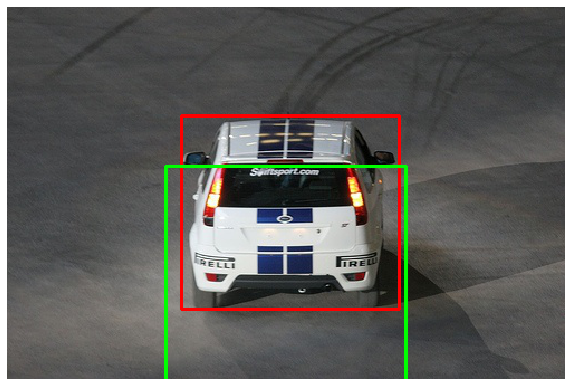

tensor([False,  True,  True, False], device='cuda:0')
tensor([[2.5000, 2.5000, 4.5000, 4.5000],
        [1.5000, 1.5000, 5.5000, 5.5000]], device='cuda:0')
2 activated anchors!


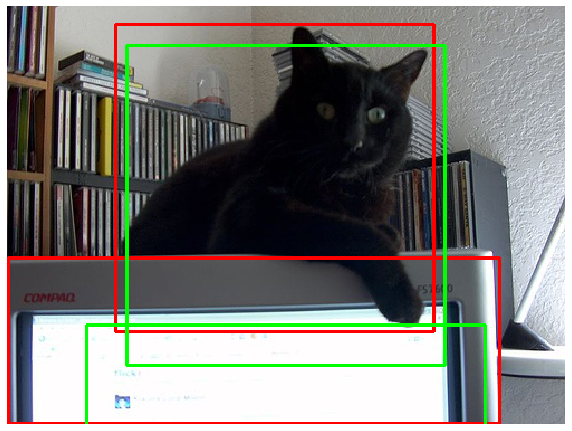

tensor([False, False, False,  True], device='cuda:0')
tensor([[5.5000, 3.5000, 7.5000, 5.5000]], device='cuda:0')
1 activated anchors!


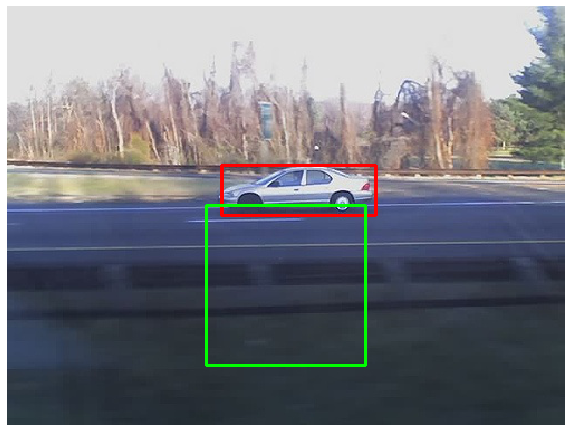

********************************************************************************
Negative anchors:
tensor([False, False, False,  True], device='cuda:0')
tensor([[5.5000, 3.5000, 7.5000, 5.5000]], device='cuda:0')
1 negative anchors!


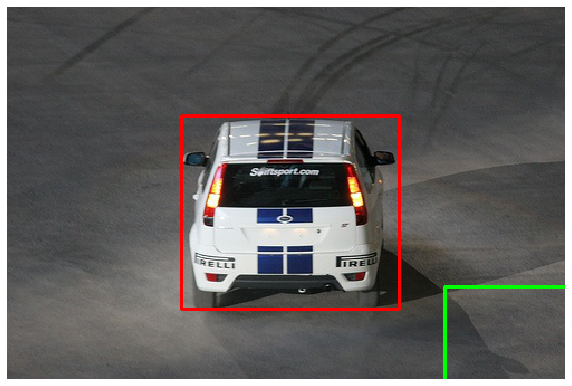

tensor([ True,  True, False, False], device='cuda:0')
tensor([[0.0000, 2.0000, 1.0000, 3.0000],
        [2.5000, 2.5000, 4.5000, 4.5000]], device='cuda:0')
2 negative anchors!


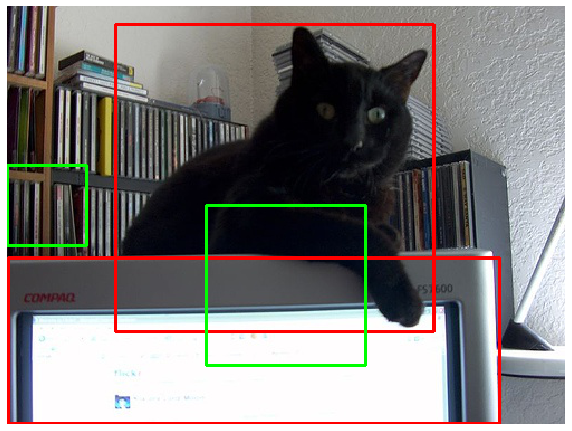

tensor([False, False,  True, False], device='cuda:0')
tensor([[1.5000, 1.5000, 5.5000, 5.5000]], device='cuda:0')
1 negative anchors!


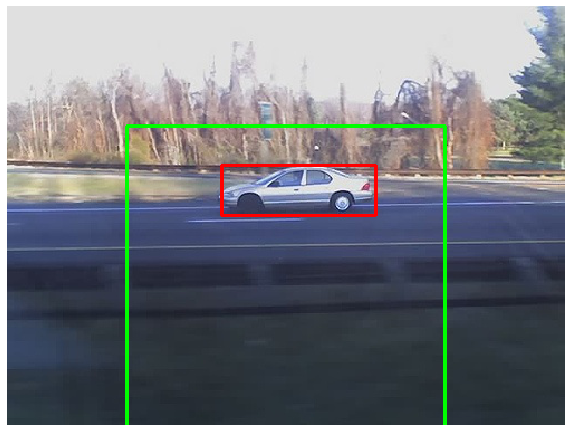

In [44]:
# visualize activated and negative anchors
anc_per_img = torch.prod(torch.tensor(anc_list.shape[1:-1])) # 441 anchors per img

print('*'*80)
print('Activated (positive) anchors:')
for img, bbox, idx in zip(img_list, box_list, torch.arange(box_list.shape[0])):
  anc_ind_in_img = (activated_anc_ind >= idx * anc_per_img) & (activated_anc_ind < (idx+1) * anc_per_img)
  print(anc_ind_in_img)
  print(negative_anc_coord[anc_ind_in_img])
  print('{} activated anchors!'.format(torch.sum(anc_ind_in_img)))
  detection_visualizer(img, idx_to_class, bbox[:, :4], coord_trans(activated_anc_coord[anc_ind_in_img], w_list[idx], h_list[idx]))

print('*'*80)
print('Negative anchors:')
for img, bbox, idx in zip(img_list, box_list, torch.arange(box_list.shape[0])):
  anc_ind_in_img = (negative_anc_ind >= idx * anc_per_img) & (negative_anc_ind < (idx+1) * anc_per_img)
  print(anc_ind_in_img)
  print(negative_anc_coord[anc_ind_in_img])
  print('{} negative anchors!'.format(torch.sum(anc_ind_in_img)))
  detection_visualizer(img, idx_to_class, bbox[:, :4], coord_trans(negative_anc_coord[anc_ind_in_img], w_list[idx], h_list[idx]))

## Prediction Network
The prediction network inputs the **features from the backbone network**, and outputs the **classification scores** and **transformations** for each anchor.

**For each position** in the 7x7 grid of features from the backbone, the prediction network outputs **`C` numbers** to be interpreted as **classification scores** over the `C` object categories for the anchors at that position.

In addition, for **each of the `A` anchors at each position**, the prediction network outputs **a transformation** (4 numbers, to convert the anchor box into a region proposal) and **a confidence score** (where large positive values indicate high probability that the anchor contains an object, and large negative values indicate low probability that the anchor contains an object).

Collecting all of these outputs, we see that **for each position** in the 7x7 grid of features we need to **output a total of `5A+C` numbers**, so the prediction network receives an input tensor of shape `(B, 1280, 7, 7)` and produces an output tensor of shape `(B, 5A+C, 7, 7)`. 

We can achieve this with **two `1x1` convolution layers** operating on the input tensor, where **the number of filters** in the **second** layer is `5A+C`.

**During training**, we **DO NOT** apply the loss on the **full set of anchor boxes** for the image; instead we designate **a subset of anchors** as positive and negative by matching them with ground-truth boxes as in the function above. The Prediction network is also responsible for **picking out the outputs** corresponding to the positive and negative anchors.

Implement `PredictionNetwork` in `single_stage_detector.py` and run the following to check your implementation. You should see errors on the order of 1e-7 or less.

In [70]:
def ReferenceOnActivatedAnchors(anchors, bboxes, grid, iou_mat, pos_thresh=0.7, neg_thresh=0.3, method='FasterRCNN'):
  """
  Determine the activated (positive) and negative anchors for model training.

  For YOLO - A grid cell is responsible for predicting a GT box if the center of
  the box falls into that cell.
  Implementation details: First compute manhattan distance between grid cell centers
  (BxH’xW’) and GT box centers (BxN). This gives us a matrix of shape Bx(H'xW')xN and
  perform torch.min(dim=1)[1] on it gives us the indexes indicating activated grids
  responsible for GT boxes (convert to x and y). Among all the anchors associated with
  the activate grids, the anchor with the largest IoU with the GT box is responsible to
  predict (regress to) the GT box.
  Note: One anchor might match multiple GT boxes.

  For Faster R-CNN - Positive anchors are defined Any of the two
  (i) the anchor/anchors with the highest IoU overlap with a GT box, or
  (ii) an anchor that has an IoU overlap higher than 0.7 with any GT box.
  Note: One anchor can match at most one GT box (the one with the largest IoU overlapping).

  For both - We assign a negative label to a anchor if its IoU ratio is lower than
  a threshold value for all GT boxes. Anchors that are neither positive nor negative
  do not contribute to the training objective.

  Main steps include:
  i) Decide activated and negative anchors based on the IoU matrix.
  ii) Compute GT confidence score/offsets/object class on the positive proposals.
  iii) Compute GT confidence score on the negative proposals.
  
  Inputs:
  - anchors: Anchor boxes, of shape BxAxH’xW’x4
  - bboxes: GT boxes of shape BxNx5, where N is the number of PADDED GT boxes,
            5 indicates (x_{lr}^{gt}, y_{lr}^{gt}, x_{rb}^{gt}, y_{rb}^{gt}) and class index
  - grid (float): A cell grid of shape BxH'xW'x2 where 2 indicate the (x, y) coord
  - iou_mat: IoU matrix of shape Bx(AxH’xW’)xN
  - pos_thresh: Positive threshold value
  - neg_thresh: Negative threshold value
  - method: Switch between 'YOLO' mode and 'FasterRCNN' mode
  
  Outputs:
  - activated_anc_ind: Index on activated anchors, of shape M, where M indicates the 
                       number of activated anchors
  - negative_anc_ind: Index on negative anchors, of shape M
  - GT_conf_scores: GT IoU confidence scores on activated anchors, of shape M
  - GT_offsets: GT offsets on activated anchors, of shape Mx4. They are denoted as
                \hat{t^x}, \hat{t^y}, \hat{t^w}, \hat{t^h} in the formulation earlier.
  - GT_class: GT class category on activated anchors, essentially indexed from bboxes[:, :, 4],
              of shape M
  - activated_anc_coord: Coordinates on activated anchors (mainly for visualization purposes)
  - negative_anc_coord: Coordinates on negative anchors (mainly for visualization purposes)
  """
  
  assert(method in ['FasterRCNN', 'YOLO'])

  B, A, h_amap, w_amap, _ = anchors.shape
  N = bboxes.shape[1]

  # activated/positive anchors
  max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)
  if method == 'FasterRCNN':
    max_iou_per_box = iou_mat.max(dim=1, keepdim=True)[0]
    activated_anc_mask = (iou_mat == max_iou_per_box) & (max_iou_per_box > 0)
    activated_anc_mask |= (iou_mat > pos_thresh) # using the pos_thresh condition as well
    # if an anchor matches multiple GT boxes, choose the box with the largest iou
    activated_anc_mask = activated_anc_mask.max(dim=-1)[0] # Bx(AxH’xW’)
    activated_anc_ind = torch.nonzero(activated_anc_mask.view(-1)).squeeze(-1)

    # GT conf scores
    GT_conf_scores = max_iou_per_anc[activated_anc_mask] # M

    # GT class
    box_cls = bboxes[:, :, 4].view(B, 1, N).expand((B, A*h_amap*w_amap, N))
    GT_class = torch.gather(box_cls, -1, max_iou_per_anc_ind.unsqueeze(-1)).squeeze(-1) # M
    GT_class = GT_class[activated_anc_mask].long()

    bboxes_expand = bboxes[:, :, :4].view(B, 1, N, 4).expand((B, A*h_amap*w_amap, N, 4))
    bboxes = torch.gather(bboxes_expand, -2, max_iou_per_anc_ind.unsqueeze(-1) \
      .unsqueeze(-1).expand(B, A*h_amap*w_amap, 1, 4)).view(-1, 4)
    bboxes = bboxes[activated_anc_ind]
  else:
    bbox_mask = (bboxes[:, :, 0] != -1) # BxN, indicate invalid boxes
    bbox_centers = (bboxes[:, :, 2:4] - bboxes[:, :, :2]) / 2. + bboxes[:, :, :2] # BxNx2

    mah_dist = torch.abs(grid.view(B, -1, 2).unsqueeze(2) - bbox_centers.unsqueeze(1)).sum(dim=-1) # Bx(H'xW')xN
    min_mah_dist = mah_dist.min(dim=1, keepdim=True)[0] # Bx1xN
    grid_mask = (mah_dist == min_mah_dist).unsqueeze(1) # Bx1x(H'xW')xN

    reshaped_iou_mat = iou_mat.view(B, A, -1, N)
    anc_with_largest_iou = reshaped_iou_mat.max(dim=1, keepdim=True)[0] # Bx1x(H’xW’)xN
    anc_mask = (anc_with_largest_iou == reshaped_iou_mat) # BxAx(H’xW’)xN
    activated_anc_mask = (grid_mask & anc_mask).view(B, -1, N)
    activated_anc_mask &= bbox_mask.unsqueeze(1)
    
    # one anchor could match multiple GT boxes
    activated_anc_ind = torch.nonzero(activated_anc_mask.view(-1)).squeeze(-1)
    GT_conf_scores = iou_mat.view(-1)[activated_anc_ind]
    bboxes = bboxes.view(B, 1, N, 5).repeat(1, A*h_amap*w_amap, 1, 1).view(-1, 5)[activated_anc_ind]
    GT_class = bboxes[:, 4].long()
    bboxes = bboxes[:, :4]
    activated_anc_ind = (activated_anc_ind / float(activated_anc_mask.shape[-1])).long()

  print('number of pos proposals: ', activated_anc_ind.shape[0])
  activated_anc_coord = anchors.view(-1, 4)[activated_anc_ind]

  # GT offsets
  # bbox and anchor coordinates are x_tl, y_tl, x_br, y_br
  # offsets are t_x, t_y, t_w, t_h
  wh_offsets = torch.log((bboxes[:, 2:4] - bboxes[:, :2]) \
    / (activated_anc_coord[:, 2:4] - activated_anc_coord[:, :2]))

  xy_offsets = (bboxes[:, :2] + bboxes[:, 2:4] - \
    activated_anc_coord[:, :2] - activated_anc_coord[:, 2:4]) / 2.

  if method == "FasterRCNN":
    xy_offsets /= (activated_anc_coord[:, 2:4] - activated_anc_coord[:, :2])
  else:
    assert torch.max(torch.abs(xy_offsets)) <= 0.5, \
      "x and y offsets should be between -0.5 and 0.5! Got {}".format( \
      torch.max(torch.abs(xy_offsets)))

  GT_offsets = torch.cat((xy_offsets, wh_offsets), dim=-1)

  # negative anchors
  negative_anc_mask = (max_iou_per_anc < neg_thresh) # Bx(AxH’xW’)
  negative_anc_ind = torch.nonzero(negative_anc_mask.view(-1)).squeeze(-1)
  negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (activated_anc_ind.shape[0],))]
  negative_anc_coord = anchors.view(-1, 4)[negative_anc_ind.view(-1)]
  
  # activated_anc_coord and negative_anc_coord are mainly for visualization purposes
  return activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
         activated_anc_coord, negative_anc_coord

In [71]:
class PredictionNetwork(nn.Module):
  def __init__(self, in_dim, hidden_dim=128, num_anchors=9, num_classes=20, drop_ratio=0.3):
    super().__init__()

    assert(num_classes != 0 and num_anchors != 0)
    self.num_classes = num_classes
    self.num_anchors = num_anchors

    ############################################################################
    # TODO: Set up a network that will predict outputs for all anchors.
    # This network should have a 1x1 convolution with hidden_dim filters,
    # then followed by a Dropout layer with p=drop_ratio,
    #                  a Leaky ReLU nonlinearity,
    #         finally  another 1x1 convolution layer to predict all outputs.
    # You can use an nn.Sequential for this network, and store it in a member variable.
    # HINT: The output should be of shape (B, 5A+C, 7, 7),
    #       where, A = self.num_anchors, C = self.num_classes.
    ############################################################################
    # Make sure to name your prediction network pred_layer.
    self.pred_layer = nn.Sequential(
        nn.Conv2d(in_dim, hidden_dim, kernel_size=1, stride=1, padding=0),
        nn.Dropout2d(p=drop_ratio),
        nn.LeakyReLU(),
        nn.Conv2d(hidden_dim, 5*self.num_anchors+self.num_classes, kernel_size=1,
                  stride=1, padding=0)
        )
    ############################################################################

  def _extract_anchor_data(self, anchor_data, anchor_idx):
    """
    INPUTS:
      - anchor_data: Tensor of shape (B, A, D, H, W) gives a vector of length D
        for each of A anchors at each point in an H x W grid.
      
      - anchor_idx: int64 Tensor of shape (M,) giving anchor indices to extract
    
    RETURNS:
      - extracted_anchors: Tenshor of shape (M, D) giving anchor data for each
        of the anchors specified by anchor_idx.
    """

    B, A, D, H, W = anchor_data.shape
    anchor_data = anchor_data.permute(0, 1, 3, 4, 2).contiguous().view(-1, D) # (B*A*H*W, D)
    extracted_anchors = anchor_data[anchor_idx] # (M, D)

    return extracted_anchors
  
  def _extract_class_scores(self, all_scores, anchor_idx):
    """
    INPUTS:
      - all_scores: Tensor of shape (B, C, H, W) giving classification scores for 
        C classes at each point in an HxW grid.
      
      - anchor_idx: int64 Tensor of shape (M,) giving the indices of anchors at which
        to extract classification scores.
      
    RETURNS:
      - extracted_scores: Tensor of shape (M, C) giving the classification scores
        for each of the anchors specified by anchor_idx.
    """

    B, C, H, W = all_scores.shape
    A = self.num_anchors
    all_scores = all_scores.contiguous().permute(0, 2, 3, 1).contiguous() # (B, H, W, C)
    all_scores = all_scores.view(B, 1, H, W, C).expand(B, A, H, W, C)
    all_scores = all_scores.reshape(B * A * H * W, C)
    extracted_scores = all_scores[anchor_idx]

    return extracted_scores

  def forward(self, features, pos_anchor_idx=None, neg_anchor_idx=None):
    """
    Run the forward pass of the network to predict outputs given features
    from the backbone network.

    Inputs:
      - features: Tensor of shape (B, in_dim, 7, 7) giving image features computed
        by the backbone network.
      
      - pos_anchor_idx: int64 Tensor of shape (M,) giving the indices of positive
        anchors. 
        NOTE: pos_anchor_idx is only given during training; 
              at test time, this should be None.
      
      - neg_anchor_idx: int64 Tensor of shape (M,) giving the indices of negative
        anchors.
        NOTE: neg_anchor_idx is only given during training;
              at test time, this should be None.

    The OUTPUTS of this method are DIFFERENT during training and inference.

    ########################## During TRAINING #################################
      
      pos_anchor_idx and neg_anchor_idx are given and identify which anchors should
      be positive and negative, and this forward pass needs to 
      ** extract only the predictions for the positive and negative anchors.**

    Outputs:
      
      - conf_scores: Tensor of shape (2 * M, 1) giving the predicted confidence
      scores for positive anchors and negative anchors (in that order).

      - offsets: Tensor of shape (M, 4) giving predicted transformation for 
      positive anchors.

      - class_scores: Tensor of shape (M, C) giving classification scores for 
      positive anchors.
    
    ########################## During INFERENCE ################################

      only features are provided, and this method needs to return predictions for
      all anchors.

    Outputs:

      - conf_scores: Tensor of shape (B, A, H, W) giving predicted confidence scores
      for all anchors.

      - offsets: Tensor of shape (B, A, 4, H, W) giving predicted transformations
      for all anchors.

      - class_scores: Tensor of shape (B, C, H, W) giving classification scores
      for each spatial position.
    """

    conf_scores, offsets, class_scores = None, None, None
    ############################################################################
    # TODO: Use backbone features to predict conf_scores, offsets, and class_scores.
    # Make sure conf_scores is between 0 and 1 by squashing the network output with a
    # sigmoid. 
    # 
    # Make sure the first two elements t^x and t^y of offsets are between -0.5 and 0.5
    # by squashing with a sigmoid and subtracting 0.5
    #
    # During TRAINING, you need to extract the outputs for only positive and 
    # negative anchors as specified above.
    #
    # HINT: You can use the provided helper methods self._extract_anchor_data
    # and self._extract_class_scores to extract information for positive and
    # negative anchors specified by pos_anchor_idx and neg_anchor_idx.
    ############################################################################
    outputs = self.pred_layer(features) # (B, in_dim, H, W) -> (B, 5A+C, H, W)
    B, _, H, W = outputs.shape

    class_scores = outputs[:, -self.num_classes:, :, :] # (B, C, H, W)

    conf_scores = outputs[:, :5*self.num_anchors:5, :, :] # (B, A, H, W)
    conf_scores = torch.sigmoid(conf_scores)

    offsets = outputs[:, :5*self.num_anchors, :, :] # (B, 5A, H, W)
    offsets = offsets.reshape(B, self.num_anchors, 5, H, W) # (B, A, 5, H, W)
    offsets = offsets[:, :, 1:] # (B, A, 4, H, W)
    offsets[:, :, :2] = torch.sigmoid(offsets[:, :, :2]) - 0.5

    if pos_anchor_idx is not None or neg_anchor_idx is not None:
      # TRAINING mode
      ###################### For Postive anchors ###############################
      offsets = self._extract_anchor_data(offsets, pos_anchor_idx) # (M, 4)
      class_scores = self._extract_class_scores(class_scores, pos_anchor_idx) # (M, C)
      ###################### For Positive & Negative anchors ###################
      conf_scores = torch.cat([conf_scores.reshape(-1).unsqueeze(-1)[pos_anchor_idx],
                               conf_scores.reshape(-1).unsqueeze(-1)[neg_anchor_idx]], dim=0) # (2*M, 1)

    return conf_scores, offsets, class_scores

In [72]:
#from single_stage_detector import PredictionNetwork

# sanity check
reset_seed(0)
pred_network = PredictionNetwork(1280, drop_ratio=0).to(dtype=torch.float32, device='cuda')
features = torch.linspace(-10., 10., steps=3*1280*7*7, dtype=torch.float32, device='cuda').view(3, 1280, 7, 7)
pos_anchor_idx = torch.tensor([122, 605, 871, 955], dtype=torch.int64, device='cuda')
neg_anchor_idx = torch.tensor([1048, 1292, 1124, 1092], dtype=torch.int64, device='cuda')
conf_scores, offsets, class_prob = pred_network(features, pos_anchor_idx, neg_anchor_idx)

expected_conf_scores = torch.tensor([[0.85080749], [0.55230302], [0.45239496], [0.51819414],
                                     [0.38467780], [0.82627463], [0.53837817], [0.538446366]], dtype=torch.float32, device='cuda')
expected_offsets = torch.tensor([[-0.16344640,  0.45598251, -1.56108809, -1.96177566],
                                 [ 0.09087485, -0.11321104,  0.46109992,  0.13557276],
                                 [ 0.14098871, -0.04003078, -0.14689390,  0.01480492],
                                 [-0.22611487,  0.14513946, -1.26124716,  0.58137202]], dtype=torch.float32, device='cuda')
expected_class_prob = torch.tensor([0.88649291, 1.08752346, 0.90241265, 1.28021181, 0.77324629,
                                    -0.93609941, 1.44269419, -1.01072836, 0.09888625, -0.09179375,
                                    -0.48814785, -1.14749694, 0.24533349, -0.19522685, 0.21445289,
                                    0.91779679, 0.97305167, 1.01984429, -0.11932681, 0.34998628], dtype=torch.float32, device='cuda')

print('conf scores error: ', rel_error(conf_scores, expected_conf_scores))
print('offsets error: ', rel_error(offsets, expected_offsets))
print('class prob error: ', rel_error(class_prob.mean(0), expected_class_prob))

conf scores error:  7.005655385366391e-08
offsets error:  1.822980344382863e-07
class prob error:  1.2394442728502706e-07


## Loss Function
The **confidence score regression loss** is for both activated/negative anchors 

While the **bounding box regression loss** and the **object classification loss** are for activated anchors only. These are implemented for you. You can see the functions `ConfScoreRegression` and `BboxRegression` in `single_stage_detector.py`, and `ObjectClassification` in `a5_helper.py`.

Run the following to check your implementation. You should see errors on the order of 1e-8 or less.

In [49]:
conf_scores.shape, GT_conf_scores.shape

(torch.Size([8, 1]), torch.Size([4]))

In [50]:
GT_conf_scores

tensor([0.7454, 0.7279, 0.7604, 0.3712], device='cuda:0')

In [55]:
def ConfScoreRegression(conf_scores, GT_conf_scores):
  """
  Use sum-squared error as in YOLO.

  Inputs:
    - conf_scores: Predicted confidence scores, (2M, 1)
    - GT_conf_scores: GT confidence scores, (M,)

  Outputs:
    - conf_score_loss
  """

  # NOTE: Target conf_scores for Negative Samples are zeros.
  # (2M, 1)
  GT_conf_scores = torch.cat((torch.ones_like(GT_conf_scores),
                              torch.zeros_like(GT_conf_scores)), dim=0).view(-1, 1)
  conf_score_loss = torch.sum((conf_scores - GT_conf_scores)**2) * 1. / GT_conf_scores.shape[0]

  return conf_score_loss


In [56]:
def BboxRegression(offsets, GT_offsets):
  """
  Use sum-squared error as in YOLO
  For both xy and wh

  Inputs:
  - offsets: Predicted box offsets (M, 2)
  - GT_offsets: GT box offsets (M, 2)

  Outputs:
  - bbox_reg_loss
  """
  bbox_reg_loss = torch.sum((offsets - GT_offsets)**2) * 1. / GT_offsets.shape[0]

In [86]:
def ObjectClassification(class_prob, GT_class, batch_size, anc_per_img, 
                         activated_anc_ind):
  """
  Use softmax loss

  Inputs:
    - class_prob: predicted class logits
    - GT_class:   GT box class label
  
  Outputs:
    - object_cls_class
  """

  # Average within sample and then average across batch
  # Such that the class_pred would not bias towards dense popular objects like `person`.
  # (M, )
  all_loss = torch.nn.functional.cross_entropy(class_prob, GT_class, reduction='none')
  object_cls_loss = 0
  for idx in range(batch_size):
    anc_ind_in_img = (activated_anc_ind >= idx * anc_per_img) & \
                    (activated_anc_ind < (idx+1) * anc_per_img)
    #print(anc_ind_in_img)
    object_cls_loss += all_loss[anc_ind_in_img].sum() * 1. / torch.sum(anc_ind_in_img)
  object_cls_loss /= batch_size

  return object_cls_loss

In [62]:
# sanity check
#from single_stage_detector import ConfScoreRegression, BboxRegression


conf_loss = ConfScoreRegression(conf_scores, GT_conf_scores)
reg_loss = BboxRegression(offsets, GT_offsets)
cls_loss = ObjectClassification(class_prob, GT_class, w_list.shape[0], anc_per_img, activated_anc_ind)
print('conf loss: {:.4f}, reg loss: {:.4f}, cls loss: {:.4f}'.format(conf_loss, reg_loss, cls_loss))

loss_all = torch.tensor([conf_loss.data, reg_loss.data, cls_loss.data], device='cuda', dtype=torch.float32)
expected_loss = torch.tensor([0.27064770460128784, 2.9750006198883057, 2.3919472694396973], device='cuda', dtype=torch.float32)

print('loss error: ', rel_error(loss_all, expected_loss))

tensor([ True, False, False, False], device='cuda:0')
tensor([False,  True,  True, False], device='cuda:0')
tensor([False, False, False,  True], device='cuda:0')
conf loss: 0.2706, reg loss: 2.9750, cls loss: 2.3919
loss error:  8.014067573656093e-08


# Train an object detector

## Object detection module

We will now combine everything into the `SingleStageDetector` class in `single_stage_detector.py`. Implement the `forward` function of our detector. This implements the training-time forward pass: it receives the input images and the ground-truth bounding boxes, and returns the total loss for the minibatch.

In [87]:
class SingleStageDetector(nn.Module):
  def __init__(self):
    super().__init__()

    self.anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3],
                                     [3, 2], [3, 5], [5, 3]]).float().cuda()
    # Backbone Network
    self.feat_extractor = FeatureExtractor()
    self.num_classes = 20
    # Prediction Network
    self.pred_network = PredictionNetwork(1280, num_anchors=self.anchor_list.shape[0],
                                          num_classes=self.num_classes)
  
  def forward(self, images, bboxes):
    """
    Training-time forward pass for the single-stage detector.

    Inputs:
      - images: Input images, of shape (B, 3, 224, 224)
      - bboxes: GT bounding boxes of shape (B, N, 5) (padded) on the activation map coordinate system

    Outputs:
      - total_loss:
        torch scalar giving the total loss for the batch
    """
    # weights to multiple to each loss term
    w_conf = 1 # for conf_scores
    w_reg = 1  # for offsets
    w_cls = 1  # for class_prob

    total_loss = None
    ############################################################################
    # TODO: IMPLEMENT the forward pass of SingleStageDetector
    # A few key steps are outlined as follows:
    #   i) Image feature extraction;
    #  ii) Grid and anchor generation;
    # iii) Compute IoU between anchors and GT boxes,
    #      Then determine positive / negative anchors, GT_conf_scores, GT_offsets, GT_class
    #  iv) Compute conf_scores, offsets, class_prob through the prediction network
    #   v) Compute the total loss which is formulated as:
    #      total_loss = w_conf * conf_loss + w_reg * reg_loss + w_cls * cls_loss
    #      where conf_loss is determined by ConfScoreRegression;
    #            reg_loss  is determined by BboxRegression;
    #            cls_loss  is determined by ObjectClassification.
    # HINT: set `neg_thresh=0.2` in ReferenceOnActivatedAnchors in this assgiment
    # for a better performance than with the default value.
    ############################################################################
    batch_size = bboxes.shape[0]
    
    # Use the backbone network to extract image-level features
    features = self.feat_extractor(images) # (B, 3, 224, 224) -> (B, 1280, 7, 7)

    # Generate grid and anchor
    grid_list = GenerateGrid(batch_size) # (B, H', W', 2)
    anc_list = GenerateAnchor(self.anchor_list, grid_list) # (B, A, H', W', 4)

    # Compute IoU between anchors and GT boxes
    iou_mat = IoU(anc_list, bboxes) # (B, A*H'*W', N)

    # Determine positive / negative anchors, GT_conf_scores, GT_offsets, GT_class
    # (M,)             (M,)              (M,)             (M, 4)      (M,)
    activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, _, _ = ReferenceOnActivatedAnchors(anc_list, bboxes, grid_list, iou_mat, pos_thresh=0.7,
                                                                                                                  neg_thresh=0.2, method='YOLO')
    
    # Compute conf_scores, offsets, class_prob through the prediction network
    # INFERENCE: (B, A, H, W) (B, A, 4, H, W) (B, C, H, W)
    # TRAINING: (2*M, 1) (M, 4) (M, C)
    conf_scores, offsets, class_prob = self.pred_network(features,
                                                         activated_anc_ind,
                                                         negative_anc_ind)
    # Compute loss
    conf_loss = ConfScoreRegression(conf_scores, GT_conf_scores) # tensor scalar
    reg_loss = BboxRegression(offsets, GT_offsets)

    anc_per_img = torch.prod(torch.tensor(anc_list.shape[1:-1])) # A*H'*W', python scalar
    cls_loss = ObjectClassification(class_prob, GT_class, batch_size, anc_per_img, activated_anc_ind)

    total_loss = w_conf * conf_loss + w_reg * reg_loss + w_cls * cls_loss

    return total_loss
    


## Overfit small data
To make sure that everything is working as expected, we can try to overfit the detector to a small subset of data.

After 200 epochs of training you should see a total loss of around or less than 0.3.


We also implemented the `DetectionSolver` object which runs the training loop to train an single stage detector. You can inspect the DetectionSolver implementation in `single_stage_detector.py`. 

In [ ]:
def DetectionSolver(detector, train_loader, learning_rate=3e-3, lr_decay=1,
                    num_epochs=20, dtype=torch.float32, device='cpu', **kwargs):
  """
  Run optimization to train the model.
  """

  # Ship model to GPU
  detector.to(dtype=dtype, device=device)

  # Optimizer Setup
  optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, detector.parameters()), 
                              learning_rate)
  lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: lr_decay**epoch)

  # Sample minibatch data
  loss_history = []
  epoch_loss_history = []
  detector.train()
  for i in range(num_epochs):
    start_t = time.time()
    epoch_loss = 0.0

    for iter_num, data_batch in enumerate(train_loader):
      # images: (B, 3, 224, 224)
      # boxes: (B, N, 5) defined in the ORIGINAL IMAGE coordinate system
      # w_batch, h_batch: (B,)
      # _ is img_id_list: length B
      images, boxes, w_batch, h_batch, _ = data_batch
      # resized_boxes: (B, N, 5) defined in the ACTIVATION MAP coordinate system
      resized_boxes = coord_trans(boxes, w_batch, h_batch, mode='p2a')
      images = images.to(dtype=dtype, device=device)
      resized_boxes = resized_boxes.to(dtype=dtype, device=device)

      loss = detector(images, resized_boxes)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_history.append(loss.item()) # batch loss
      epoch_loss += loss.item() * images.shape[0]

      print('(Iter {} / {})'.format(iter_num, len(train_loader)))
    
    end_t = time.time()
    epoch_loss = epoch_loss / len(train_loader.dataset)
    epoch_loss_history.append(epoch_loss)
    print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(
        i, num_epochs, loss.item(), end_t-start_t))
    
    lr_scheduler.step()

  # Plot the training losses
  plt.subplot(1, 2, 1)
  plt.plot(loss_history)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training loss history')
  plt.subplot(1, 2, 2)
  plt.plot(epoch_loss_history)
  plt.xlabel('Epoch')
  plt.ylable('Loss')
  plt.show()
  




  

In [92]:
len(train_loader.dataset)

2500

In [90]:
f = lambda x, y: x+y
f(3, 4)

7

lr:  0.01
number of pos proposals:  43
(Iter 0 / 1)
(Epoch 0 / 200) loss: 4.6690 time per epoch: 0.2s
number of pos proposals:  43
(Iter 0 / 1)
(Epoch 1 / 200) loss: 3.2354 time per epoch: 0.2s
number of pos proposals:  43
(Iter 0 / 1)
(Epoch 2 / 200) loss: 2.7001 time per epoch: 0.2s
number of pos proposals:  43
(Iter 0 / 1)
(Epoch 3 / 200) loss: 2.4335 time per epoch: 0.2s
number of pos proposals:  43
(Iter 0 / 1)
(Epoch 4 / 200) loss: 1.9619 time per epoch: 0.2s
number of pos proposals:  43
(Iter 0 / 1)
(Epoch 5 / 200) loss: 1.7559 time per epoch: 0.2s
number of pos proposals:  43
(Iter 0 / 1)
(Epoch 6 / 200) loss: 1.7437 time per epoch: 0.2s
number of pos proposals:  43
(Iter 0 / 1)
(Epoch 7 / 200) loss: 1.7457 time per epoch: 0.2s
number of pos proposals:  43
(Iter 0 / 1)
(Epoch 8 / 200) loss: 1.6199 time per epoch: 0.2s
number of pos proposals:  43
(Iter 0 / 1)
(Epoch 9 / 200) loss: 1.2823 time per epoch: 0.2s
number of pos proposals:  43
(Iter 0 / 1)
(Epoch 10 / 200) loss: 1.339

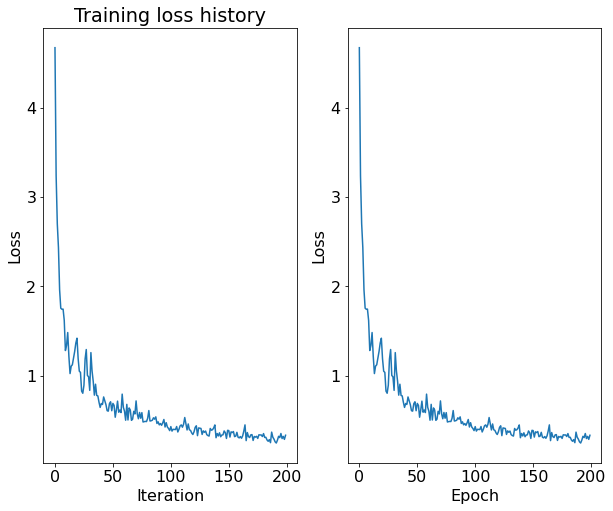

In [88]:
#from single_stage_detector import DetectionSolver

# monitor the training loss
reset_seed(0)
num_sample = 10
small_dataset = torch.utils.data.Subset(train_dataset, torch.linspace(0, len(train_dataset)-1, steps=num_sample).long())
small_train_loader = pascal_voc2007_loader(small_dataset, 10) # a new loader

for lr in [1e-2]:
  print('lr: ', lr)
  detector = SingleStageDetector()
  DetectionSolver(detector, small_train_loader, learning_rate=lr, num_epochs=200, dtype=torch.float32, device='cuda')

## Train a net

Now that we are confident that the training code is working properly, let's train the network on more data and for longer. We will train for 50 epochs; this should take about 35 minutes on a K80 GPU. You should see a total loss around or less than 0.27.

For initial debugging, you may want to train for a smaller number of epochs; training for 5 epochs, you can expect a loss of around 1.0. 

Note that real object detection systems typically train for 12-24 hours, distribute training over multiple GPUs, and use much faster GPUs. As such our result will be far from the state of the art, but it should give some reasonable results!


number of pos proposals:  283
(Iter 0 / 25)
number of pos proposals:  367
(Iter 1 / 25)
number of pos proposals:  298
(Iter 2 / 25)
number of pos proposals:  297
(Iter 3 / 25)
number of pos proposals:  298
(Iter 4 / 25)
number of pos proposals:  258
(Iter 5 / 25)
number of pos proposals:  329
(Iter 6 / 25)
number of pos proposals:  332
(Iter 7 / 25)
number of pos proposals:  303
(Iter 8 / 25)
number of pos proposals:  306
(Iter 9 / 25)
number of pos proposals:  276
(Iter 10 / 25)
number of pos proposals:  303
(Iter 11 / 25)
number of pos proposals:  282
(Iter 12 / 25)
number of pos proposals:  324
(Iter 13 / 25)
number of pos proposals:  295
(Iter 14 / 25)
number of pos proposals:  304
(Iter 15 / 25)
number of pos proposals:  317
(Iter 16 / 25)
number of pos proposals:  309
(Iter 17 / 25)
number of pos proposals:  344
(Iter 18 / 25)
number of pos proposals:  355
(Iter 19 / 25)
number of pos proposals:  352
(Iter 20 / 25)
number of pos proposals:  381
(Iter 21 / 25)
number of pos propos

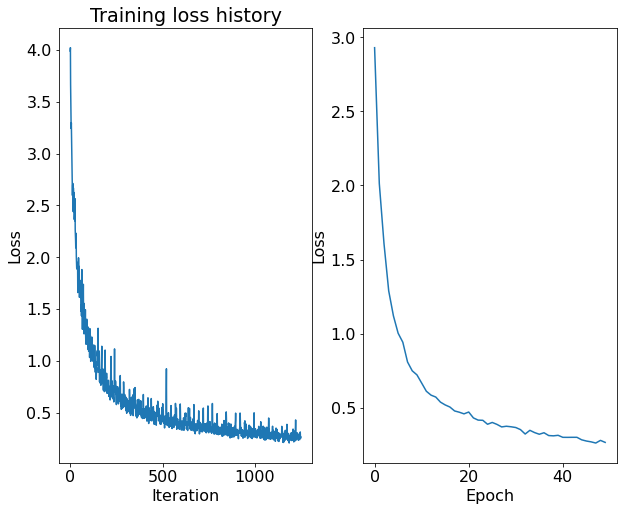

In [89]:
# monitor the training loss
train_loader = pascal_voc2007_loader(train_dataset, 100)

lr = 5e-2
num_epochs = 50
yolo_detector = SingleStageDetector().to(dtype=torch.float32, device='cuda')
DetectionSolver(yolo_detector, train_loader, learning_rate=lr, num_epochs=num_epochs, dtype=torch.float32, device='cuda')

After you've trained your model, save the weights for submission. Feel free to comment some of those lines to load earlier checkpoints. We evaluate the detector after loading as a sanity check.

In [94]:
type(yolo_detector.state_dict())

collections.OrderedDict

In [96]:
def DetectionEvaluater(detector, loader, dtype=torch.float32, device='cpu', **kwargs):
  """
  Evaluate the mode
  """
  # ship model to corresponding device
  detector.to(dtype=dtype, device=device)

  # sample minibatch data
  detector.eval()
  with torch.no_grad():
    start_t = time.time()
    epoch_loss = 0.0
    for iter_num, data_batch in enumerate(loader):
      images, boxes, w_batch, h_batch, _ = data_batch
      resized_boxes = coord_trans(boxes, w_batch, h_batch, mode='p2a')
      images = images.to(dtype=dtype, device=device)
      resized_boxes = resized_boxes.to(dtype=dtype, device=device)

      epoch_loss += detector(images, resized_boxes) * images.shape[0]
    
    end_t = time.time()
  
  # divide by number of instances
  epoch_loss = epoch_loss / len(loader.dataset)
  print(f'Epoch loss: {epoch_loss:.4f}')
  return epoch_loss

In [97]:
weights_path = os.path.join(GOOGLE_DRIVE_PATH, "yolo_detector.pt")
torch.save(yolo_detector.state_dict(), weights_path)

yolo_detector = SingleStageDetector().to(dtype=torch.float32, device='cuda')
yolo_detector.load_state_dict(torch.load(weights_path))
DetectionEvaluater(yolo_detector, train_loader, dtype=torch.float32, device='cuda')


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


number of pos proposals:  283
number of pos proposals:  367
number of pos proposals:  298
number of pos proposals:  297
number of pos proposals:  298
number of pos proposals:  258
number of pos proposals:  329
number of pos proposals:  332
number of pos proposals:  303
number of pos proposals:  306
number of pos proposals:  276
number of pos proposals:  303
number of pos proposals:  282
number of pos proposals:  324
number of pos proposals:  295
number of pos proposals:  304
number of pos proposals:  317
number of pos proposals:  309
number of pos proposals:  344
number of pos proposals:  355
number of pos proposals:  352
number of pos proposals:  381
number of pos proposals:  290
number of pos proposals:  286
number of pos proposals:  356
Epoch loss: 0.2411


tensor(0.2411, device='cuda:0')

# Use an object detector

## Non-Maximum Suppression (NMS)
The definition of NMS and instructions on how to compute NMS can be found in the lecture slides (p40-44):
https://web.eecs.umich.edu/~justincj/slides/eecs498/FA2020/598_FA2020_lecture15.pdf

Implement the `nms` function in `single_stage_detector.py`. We then compare your implementation of NMS with the implementation in torchvision. Most likely, your implementation will be faster on CPU than on CUDA, and the torchvision implementation will likely be much faster than yours. This is expected, but your implementation should produce the same outputs as the torchvision version.

In [156]:
def IoU(proposals, bboxes):
  """
  Compute intersection over union between sets of bounding boxes.
  Inputs:
  - proposals: Proposals of shape (B, A, H', W', 4)
  - bboxes: Ground-truth boxes from the DataLoader of shape (B, N, 5).
    Each ground-truth box is represented as tuple (x_lr, y_lr, x_rb, y_rb, class).
    If image i has fewer than N boxes, then bboxes[i] will be padded with extra
    rows of -1.
  
  Outputs:
  - iou_mat: IoU matrix of shape (B, A*H'*W', N) where iou_mat[b, i, n] gives
    the IoU between one element of proposals[b] and bboxes[b, n].
  For this implementation you DO NOT need to filter invalid proposals or boxes;
  in particular you don't need any special handling for bboxxes that are padded
  with -1.
  """
  iou_mat = None
  ##############################################################################
  # TODO: Compute the Intersection over Union (IoU) on proposals and GT boxes. #
  # No need to filter invalid proposals/bboxes (i.e., allow region area <= 0). #
  # However, you need to make sure to compute the IoU correctly (it should be  #
  # 0 in those cases.                                                          # 
  # You need to ensure your implementation is efficient (no for loops).        #
  # HINT:                                                                      #
  # IoU = Area of Intersection / Area of Union, where                          #
  # Area of Union = Area of Proposal + Area of BBox - Area of Intersection     #
  # and the Area of Intersection can be computed using the top-left corner and #
  # bottom-right corner of proposal and bbox. Think about their relationships. #
  ##############################################################################
  # Replace "pass" statement with your code

  # Reduce 'proposals' shape by flattening its intern dimensions.
  # Transorm 'proposals' from a 5-D tensor of shape (B, A, H', W', 4)
  # to 3-D tensor of shape (B, A*H'*W', 4)
  proposals = torch.flatten(proposals, start_dim=1, end_dim=-2)

  # Compute for each proposal, its rectangle area: (x_rb - x_lr) * (y_rb - y_lr)
  # Output is a 2-D tensor of shape (B, A*H'*W')
  proposals_area = (proposals[..., 2] - proposals[..., 0]) * \
                    (proposals[..., 3] - proposals[..., 1])

  # Add one dimension to 'bboxes'. This is needed for further operations.
  # 'bboxes' will have a shape of (B, 1, N, 5)
  bboxes = torch.unsqueeze(bboxes, dim=1)

  # Compute for each bbox, its rectangle area.
  # Output is a 3-D tensor of shape (B, 1, N)
  bboxes_area = (bboxes[..., 2] - bboxes[..., 0]) * \
                (bboxes[..., 3] - bboxes[..., 1])

  # Compute the area of 'redundent union' (union without subtracting the intersection).
  # "transpose" operation was used to allow tensors fit the broadcasting.
  # In terms of shapes, this operation will result in:
  # red_union.shape = [(B, A*H'*W').T + (B, 1, N).T].T
  #                 = [(A*H'*W', B) + (N, 1, B)].T
  #                 = (N, A*H'*W', B).T
  #                 = (B, A*H'*W', N)
  # 'red_union' is a 3-D tensor of shape (B, A*H'*W', N)
  red_union = (proposals_area.T + bboxes_area.T).T

  # Add one dimension to 'bboxes'. This is needed for further operations.
  # 'proposals' will be a 4-D tensor of shape (B, A*H'*W', 1, 4)
  proposals = torch.unsqueeze(proposals, dim=2)

  # Get the maximums/minimums between 'bboxes' coordinates and proposals 'coordinates'
  # Note that for 'bboxes', we don't take the last value of the last axis since it represents the class.
  # Output is a 4-D tensor of shape (B, A*H'*W', N, 4)
  maxs = torch.maximum(bboxes[..., :4], proposals)
  mins = torch.minimum(bboxes[..., :4], proposals)

  # Compute the intersections heights (min_x_rb - max_x_lr) and widths (min_y_rb - max_y_lr)
  # Output is a 3-D tensor of shape (B, A*H'*W', N)
  inter_heights = mins[..., 2] - maxs[..., 0]
  inter_widths = mins[..., 3] - maxs[..., 1]

  # Turn all negative heights/widths to zero.
  # This should be done BEFORE computing the intersection to avoid the case where
  # both 'inter_heights' and 'inter_widths' are negative, which will result in a
  # positive value (which is incorrect, we expect this case to result in 0).
  inter_heights[inter_heights < 0] = 0
  inter_widths[inter_widths < 0] = 0

  # Compute the intersection rectangle area.
  inter_area = inter_heights * inter_widths

  # Compute the IoU, which equals to: Area of Intersection / Area of Union
  iou_mat = inter_area / (red_union - inter_area)

  ##############################################################################
  #                               END OF YOUR CODE                             #
  ##############################################################################
  return iou_mat

In [161]:
def nms(boxes, scores, iou_threshold=0.5, topk=None):
  """
  Non-maximum suppression removes overlapping bounding boxes.

  Inputs:
    - boxes: top_left and bottom_right coordinate values of the bounding boxes
            to perform NMS on, of shape (N, 4)
    - scores: scores for each one of the boxes, of shape N.
    - iou_threshold: discards all overlapping boxes with IoU > iou_threshold
    - topk: If this is not None, then return only the topk highest-scoreing boxes.
    Otherwise, if this is None, then return all boxes that pass NMS.
  
  Outputs:
    - keep: torch.long tensor, with the indices of the elements that have been
      kept by NMS, sorted in decreasing order of scores; of shape [num_kept_boxes]
  """
  ##############################################################################
  # TODO: Implement non-maximum suppression which iterates the following:
  #       1. Select the highest-scoring box among the remaining ones,
  #          which has not been chosen in this step before.
  #       2. Eliminate boxes with IoU > threshold
  #       3. If any boxes remain, GOTO 1
  #
  # Your implementation should not depend on a specific device type, 
  # you can use the device of the input if necessary.
  # credit to nms implementation of 
  # https://github.com/seloufian/Deep-Learning-Computer-Vision/blob/master/eecs498-007/A5/single_stage_detector.py
  ##############################################################################

  if (not boxes.numel()) or (not scores.numel()):
    return torch.zeros(0, dtype=torch.long)

  # initialization
  keep = []

  # Sort the bounding box from the highest-scoring confidence to the lowest-scoring.
  score_indices = torch.sort(scores, descending=True)[1]
  boxes = boxes[score_indices] # (N, 4)

  # if any boxes remain, continue
  while boxes.shape[0] > 0:

    keep.append(score_indices[0])

    highest_scoring_box = boxes[0] # (4,)
    # remove the highest-scoring box
    boxes = boxes[1:] # (N-1, 4)
    score_indices = score_indices[1:]

    highest_scoring_box = highest_scoring_box.reshape(1, 1, 4)
    remaining_boxes = boxes.reshape(1, -1, 1, 1, 4)
    #print(f'highest_scoring_box {highest_scoring_box.shape}')
    #print(f'remaining_boxes {remaining_boxes.shape}')
    iou_mat = IoU(remaining_boxes, highest_scoring_box).squeeze() # (1, N-1, 1)
    #print(f'iou_mat shape {iou_mat.shape}')

    discard_mask = ~ (iou_mat > iou_threshold) # (N-1, 1)

    boxes = boxes[discard_mask] # the order will still be sorted
    score_indices = score_indices[discard_mask]
  
  keep = torch.LongTensor(keep)
  
  return keep

In [162]:
#from single_stage_detector import nms

reset_seed(0)
boxes = (100. * torch.rand(5000, 4)).round()
boxes[:,2] = boxes[:,2] + boxes[:,0] + 1.
boxes[:,3] = boxes[:,3] + boxes[:,1] + 1.
scores = torch.randn(5000)

names = ['your_cpu', 'torchvision_cpu', 'torchvision_cuda']
iou_thresholds = [0.3, 0.5, 0.7]
elapsed = dict(zip(names, [0.]*len(names)))
intersects = dict(zip(names[1:], [0.]*(len(names)-1)))

for iou_threshold in iou_thresholds:
  tic = time.time()
  my_keep = nms(boxes, scores, iou_threshold)
  elapsed['your_cpu'] += time.time() - tic
 
  tic = time.time()
  tv_keep = torchvision.ops.nms(boxes, scores, iou_threshold)
  elapsed['torchvision_cpu'] += time.time() - tic
  intersect = len(set(tv_keep.tolist()).intersection(my_keep.tolist())) / len(tv_keep)
  intersects['torchvision_cpu'] += intersect

  tic = time.time()
  tv_cuda_keep = torchvision.ops.nms(boxes.cuda(), scores.cuda(), iou_threshold).to(my_keep.device)
  torch.cuda.synchronize()
  elapsed['torchvision_cuda'] += time.time() - tic
  intersect = len(set(tv_cuda_keep.tolist()).intersection(my_keep.tolist())) / len(tv_cuda_keep)
  intersects['torchvision_cuda'] += intersect

for key in intersects:
  intersects[key] /= len(iou_thresholds)

# You should see < 1% difference
print('Testing NMS:')
print('Your        CPU  implementation: %fs' % elapsed['your_cpu'])
print('torchvision CPU  implementation: %fs' % elapsed['torchvision_cpu'])
print('torchvision CUDA implementation: %fs' % elapsed['torchvision_cuda'])
print('Speedup CPU : %fx' % (elapsed['your_cpu'] / elapsed['torchvision_cpu']))
print('Speedup CUDA: %fx' % (elapsed['your_cpu'] / elapsed['torchvision_cuda']))
print('Difference CPU : ', 1. - intersects['torchvision_cpu']) # in the order of 1e-3 or less
print('Difference CUDA: ', 1. - intersects['torchvision_cuda']) # in the order of 1e-3 or less

Testing NMS:
Your        CPU  implementation: 1.685910s
torchvision CPU  implementation: 0.074242s
torchvision CUDA implementation: 0.007154s
Speedup CPU : 22.708276x
Speedup CUDA: 235.644528x
Difference CPU :  0.0012674271229404788
Difference CUDA:  0.0


## Inference

Now, implement the inference part of module `SingleStageDetector`. Once you're done, test your implementation using the overfitted model weights. 

Visualize the output from the overfitted model on the small dataset by running the code box below, the bounding boxes should be really accurate.

In [163]:
class SingleStageDetector(nn.Module):
  def __init__(self):
    super().__init__()

    self.anchor_list = torch.tensor([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [2, 3],
                                     [3, 2], [3, 5], [5, 3]]).float().cuda()
    # Backbone Network
    self.feat_extractor = FeatureExtractor()
    self.num_classes = 20
    # Prediction Network
    self.pred_network = PredictionNetwork(1280, num_anchors=self.anchor_list.shape[0],
                                          num_classes=self.num_classes)
  
  def forward(self, images, bboxes):
    """
    Training-time forward pass for the single-stage detector.

    Inputs:
      - images: Input images, of shape (B, 3, 224, 224)
      - bboxes: GT bounding boxes of shape (B, N, 5) (padded) on the activation map coordinate system

    Outputs:
      - total_loss:
        torch scalar giving the total loss for the batch
    """
    # weights to multiple to each loss term
    w_conf = 1 # for conf_scores
    w_reg = 1  # for offsets
    w_cls = 1  # for class_prob

    total_loss = None
    ############################################################################
    # TODO: IMPLEMENT the forward pass of SingleStageDetector
    # A few key steps are outlined as follows:
    #   i) Image feature extraction;
    #  ii) Grid and anchor generation;
    # iii) Compute IoU between anchors and GT boxes,
    #      Then determine positive / negative anchors, GT_conf_scores, GT_offsets, GT_class
    #  iv) Compute conf_scores, offsets, class_prob through the prediction network
    #   v) Compute the total loss which is formulated as:
    #      total_loss = w_conf * conf_loss + w_reg * reg_loss + w_cls * cls_loss
    #      where conf_loss is determined by ConfScoreRegression;
    #            reg_loss  is determined by BboxRegression;
    #            cls_loss  is determined by ObjectClassification.
    # HINT: set `neg_thresh=0.2` in ReferenceOnActivatedAnchors in this assgiment
    # for a better performance than with the default value.
    ############################################################################
    batch_size = bboxes.shape[0]
    
    # Use the backbone network to extract image-level features
    features = self.feat_extractor(images) # (B, 3, 224, 224) -> (B, 1280, 7, 7)

    # Generate grid and anchor
    grid_list = GenerateGrid(batch_size) # (B, H', W', 2)
    anc_list = GenerateAnchor(self.anchor_list, grid_list) # (B, A, H', W', 4)

    # Compute IoU between anchors and GT boxes
    iou_mat = IoU(anc_list, bboxes) # (B, A*H'*W', N)

    # Determine positive / negative anchors, GT_conf_scores, GT_offsets, GT_class
    # (M,)             (M,)              (M,)             (M, 4)      (M,)
    activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, _, _ = ReferenceOnActivatedAnchors(anc_list, bboxes, grid_list, iou_mat, pos_thresh=0.7,
                                                                                                                  neg_thresh=0.2, method='YOLO')
    
    # Compute conf_scores, offsets, class_prob through the prediction network
    # INFERENCE: (B, A, H, W) (B, A, 4, H, W) (B, C, H, W)
    # TRAINING: (2*M, 1) (M, 4) (M, C)
    conf_scores, offsets, class_prob = self.pred_network(features,
                                                         activated_anc_ind,
                                                         negative_anc_ind)
    # Compute loss
    conf_loss = ConfScoreRegression(conf_scores, GT_conf_scores) # tensor scalar
    reg_loss = BboxRegression(offsets, GT_offsets)

    anc_per_img = torch.prod(torch.tensor(anc_list.shape[1:-1])) # A*H'*W', python scalar
    cls_loss = ObjectClassification(class_prob, GT_class, batch_size, anc_per_img, activated_anc_ind)

    total_loss = w_conf * conf_loss + w_reg * reg_loss + w_cls * cls_loss

    return total_loss

  def inference(self, images, thresh=0.5, nms_thresh=0.7):
    """"
    Inference-time forward pass for the single stage detector.
    Inputs:
    - images: Input images
    - thresh: Threshold value on confidence scores
    - nms_thresh: Threshold value on NMS
    Outputs:
    - final_propsals: Keeped proposals after confidence score thresholding and NMS,
                      a list of B (*x4) tensors
    - final_conf_scores: Corresponding confidence scores, a list of B (*x1) tensors
    - final_class: Corresponding class predictions, a list of B  (*x1) tensors
    """
    final_proposals, final_conf_scores, final_class = [], [], []
    ##############################################################################
    # TODO: Predicting the final proposal coordinates `final_proposals`,         #
    # confidence scores `final_conf_scores`, and the class index `final_class`.  #
    # The overall steps are similar to the forward pass but now you do not need  #
    # to decide the activated nor negative anchors.                              #
    # HINT: Thresholding the conf_scores based on the threshold value `thresh`.  #
    # Then, apply NMS (torchvision.ops.nms) to the filtered proposals given the  #
    # threshold `nms_thresh`.                                                    #
    # The class index is determined by the class with the maximal probability.   #
    # Note that `final_propsals`, `final_conf_scores`, and `final_class` are all #
    # lists of B 2-D tensors (you may need to unsqueeze dim=1 for the last two). #
    ##############################################################################
    # Replace "pass" statement with your code

    # Note that in the code below, there is a lot of tensor's reshapes.
    # These operations are -unfortunately- needed to match different functions'
    # input tensors shapes criteria.

    batch_size = images.shape[0]

    # Image feature extraction (using the backbone CNN network).
    features = self.feat_extractor(images)

    # Grid and anchor generation.
    grid = GenerateGrid(batch_size)
    anchors = GenerateAnchor(self.anchor_list, grid)

    B, A, Hp, Wp, _ = anchors.shape

    # Pass 'features' through the prediction network (with inference mode).
    conf_scores, offsets, class_scores = self.pred_network(features)

    # Reshape 'conf_scores' from (B, A, H', W') to (B, A*H'*W')
    conf_scores = torch.flatten(conf_scores, start_dim=1)

    # Reshape 'offsets' from (B, A, 4, H', W') to (B, A, H', W', 4)
    offsets = torch.transpose(offsets, 2, 4)

    # Get the indices of maximums within 'class_scores'.
    # 'class_scores' has shape of (B, C, H', W')
    # 'class_indices' (the output) has shape of (B, H', W')
    class_indices = torch.max(class_scores, dim=1)[1]
    # Reshape 'class_indices' from (B, H', W') to (B, 1, H', W')
    class_indices = class_indices.unsqueeze(1)
    # Reshape via broadcasting 'class_indices' from (B, 1, H', W') to (B, A, H', W')
    class_indices = torch.broadcast_to(class_indices, (B, A, Hp, Wp))
    # Reshape 'class_indices' from (B, A, H', W') to (B, A*H'*W')
    class_indices = torch.flatten(class_indices, start_dim=1)

    proposals = GenerateProposal(anchors, offsets, method='YOLO')
    # Reshape 'proposals' from (B, A, H', W', 4) to (B, A*H'*W', 4)
    proposals = torch.flatten(proposals, start_dim=1, end_dim=-2)

    final_proposals, final_conf_scores, final_class = [], [], []

    for idx in range(batch_size):
      # Get current image's proposals, conf_scores and class_indices.
      cr_proposal = proposals[idx]       # Tensor's shape: (A*H'*W', 4)
      cr_conf_scores = conf_scores[idx]  # Tensor's shape: (A*H'*W',)
      cr_classes = class_indices[idx]    # Tensor's shape: (A*H'*W',)

      # Define a boolean mask which indicates indexes to delete.
      del_idx_mask = ~ (cr_conf_scores < thresh)

      # Apply the mask on current proposals, conf_scores and class_indices.
      cr_conf_scores = cr_conf_scores[del_idx_mask]
      # Get the number of 'cr_conf_scores' that have been [K]ept.
      K = cr_conf_scores.shape[0]

      # 'cr_classes' will have a shape of (K, 1)
      cr_classes = cr_classes[del_idx_mask].unsqueeze(1)

      # Reshape 'del_idx_mask' from (A*H'*W',) to (A*H'*W', 1)
      del_idx_mask = del_idx_mask.unsqueeze(1)
      # Reshape via broadcasting 'del_idx_mask' from (A*H'*W', 1) to (A*H'*W', 4)
      del_idx_mask = torch.broadcast_to(del_idx_mask, (A*Hp*Wp, 4))

      # 'cr_proposal' will have a shape of (K, 4)
      cr_proposal = cr_proposal[del_idx_mask].reshape(K, 4)

      # Get indices of kept proposals (using NMS).
      icr_proposal = torchvision.ops.nms(cr_proposal, cr_conf_scores, nms_thresh)

      final_proposals.append(cr_proposal[icr_proposal])
      final_conf_scores.append(cr_conf_scores[icr_proposal].unsqueeze(1))
      final_class.append(cr_classes[icr_proposal])

    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    return final_proposals, final_conf_scores, final_class



In [ ]:
DetectionInference(detector, small_train_loader, small_dataset, idx_to_class, thresh=0.8, device='cuda', dtype=torch.float32)

### Inference - train a net

In [ ]:
# visualize the same output from the model trained on the entire training set
# some bounding boxes might not make sense
DetectionInference(yolo_detector, small_train_loader, small_dataset, idx_to_class, dtype=torch.float32, device='cuda')

## Evaluation
Compute mean Average Precision (mAP). Introduction on mAP see lecture slides (p46-57): https://web.eecs.umich.edu/~justincj/slides/eecs498/FA2020/598_FA2020_lecture15.pdf


Run the following to evaluate your detector on the PASCAL VOC validation set. You should see mAP at around 11% or above.

The state of the art on this dataset is >80% mAP! To achieve these results we would need to use a much bigger network, and train with more data and for much longer, but that is beyond the scope of this assigment.

(Optional) If you train the model longer (e.g., 100 epochs), you should see a better mAP. But make sure you revert the code back for grading purposes.

In [ ]:
DetectionInference(yolo_detector, val_loader, val_dataset, idx_to_class, output_dir='mAP/input', thresh=0.8, nms_thresh=0.3, device='cuda', dtype=torch.float32)
!cd mAP && python main.py